In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from keras import Input, Model, layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
def time_step(data, ts, lag, duration):
    dataX = []
    dataY = []
    
    for i in range(len(data)-ts-(lag-1)-(duration-1)):
        dataX.append(data[i:i+ts])
        dataY.append(data[i+ts+lag-1:i+ts+lag-1+duration])
        
    dataX = np.array(dataX)
    dataY = np.array(dataY)  

    return dataX, dataY

def normalization(data_train, data_val, data_test):
    scaler = MinMaxScaler()
    scaler.fit(data_train)
    
    n_data_train = scaler.transform(data_train)
    n_data_val = scaler.transform(data_val)
    n_data_test = scaler.transform(data_test)
    
    return n_data_train, n_data_val, n_data_test

In [4]:
# 데이터 불러오기

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

df = pd.read_csv(url)

In [5]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,55733,55759,55770,55775,55827,55840,55847,55876,55876,55894
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,107931,108823,109674,110521,111301,112078,112897,113580,114209,114840
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,113255,113430,113593,113761,113948,114104,114234,114382,114543,114681
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,10889,10908,10948,10976,10998,11019,11042,11069,11089,11130
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,20854,20882,20923,20981,21026,21055,21086,21108,21114,21161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,2448,2475,2482,2488,2494,2501,2512,2524,2526,2529
270,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,185336,187309,189326,191203,193029,194548,196812,198554,200382,202378
271,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2310,2342,2363,2375,2411,2444,2473,2545,2586,2627
272,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,79002,79557,80090,80687,81341,82011,82421,82655,82897,83333


In [6]:
# 한국의 누적 확진자수를 일일 신규 확진자수로 변경

df = df[df['Country/Region'] == 'Korea, South']
df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace=True)

/home/compu/anaconda3/envs/dream/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21
158,1,1,2,2,3,4,4,4,4,11,...,90372,90816,91240,91638,92055,92471,92817,93263,93733,94198


In [8]:
df = df.T
df.columns = ['Confirmed']
df.index = pd.to_datetime(df.index)

data = []
for index, value in enumerate(df['Confirmed']):
    if index == 0:
        data.append(value)
    else:
        data.append(value - df['Confirmed'].iloc[index-1])

In [9]:
data

[1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 7,
 1,
 3,
 0,
 1,
 3,
 4,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 73,
 100,
 229,
 169,
 231,
 144,
 284,
 505,
 571,
 813,
 586,
 599,
 851,
 435,
 467,
 505,
 448,
 273,
 164,
 35,
 242,
 114,
 110,
 107,
 76,
 74,
 84,
 93,
 152,
 87,
 147,
 162,
 0,
 76,
 100,
 104,
 91,
 146,
 105,
 78,
 125,
 101,
 89,
 86,
 94,
 81,
 47,
 47,
 53,
 39,
 27,
 30,
 32,
 25,
 27,
 27,
 22,
 22,
 18,
 8,
 13,
 9,
 11,
 14,
 10,
 10,
 10,
 14,
 9,
 4,
 9,
 6,
 13,
 8,
 3,
 2,
 4,
 12,
 18,
 34,
 35,
 27,
 26,
 29,
 27,
 19,
 13,
 15,
 13,
 32,
 12,
 20,
 23,
 25,
 16,
 19,
 40,
 79,
 58,
 39,
 27,
 35,
 38,
 49,
 39,
 39,
 51,
 57,
 38,
 38,
 50,
 45,
 56,
 48,
 34,
 36,
 34,
 43,
 59,
 49,
 67,
 48,
 17,
 46,
 51,
 28,
 39,
 51,
 62,
 42,
 43,
 50,
 54,
 63,
 63,
 61,
 46,
 44,
 63,
 49,
 45,
 35,
 44,
 62,
 33,
 39,
 61,
 60,
 39,
 34,
 26,
 45,
 63,
 59,
 41,
 113,
 58,
 25,
 28,
 48,
 18,
 36,
 31,
 30,
 23,
 34,
 33,
 43,
 20,
 43,
 36,
 28,
 34

In [10]:
std_list = []
for ts in range(3, 11, 1):
    data_X, data_Y = time_step(data , ts, 1, 1)
    
    NUM_VAL = int(data_X.shape[0] * 0.8)
    test_Y =data_Y[NUM_VAL:]
    
    std_list.append(test_Y.std())

In [49]:
# Sub model 1 - DNN

rmse = []
r2 = []

for ts in range(3, 11, 1): 
    
#     train_X, train_Y = time_step(df_train, ts, 1, 1)
#     val_X, val_Y = time_step(df_val, ts, 1, 1)
#     test_X, test_Y = time_step(df_test, ts, 1, 1)

#     train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    
    # time step & lag
    data_X, data_Y = time_step(data , ts, 1, 1)
    
    # 데이터 분할
    NUM_TRAIN = int(data_X.shape[0] * 0.6)
    NUM_VAL = int(data_X.shape[0] * 0.8)

    train_X = data_X[:NUM_TRAIN]
    train_Y = data_Y[:NUM_TRAIN]

    val_X = data_X[NUM_TRAIN:NUM_VAL]
    val_Y = data_Y[NUM_TRAIN:NUM_VAL]

    test_X = data_X[NUM_VAL:]
    test_Y =data_Y[NUM_VAL:]

    train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    # 함수형 API
    input_tensor = Input(shape=(train_X.shape[1],))
    x = layers.Dense(32, activation='relu')(input_tensor)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(8, activation='relu')(x)
    output_tensor = layers.Dense(1)(x)

    model = Model(input_tensor, output_tensor)

    model.compile(loss='mse', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('./model/DNN/model_{}.h5'.format(ts), monitor='val_loss', save_best_only=True)

    model.fit(train_X, train_Y,
              batch_size=8,
              epochs=10000,
              validation_data=(val_X, val_Y),
              callbacks=[early_stopping, mc],
              shuffle=False,
              verbose=1)
    
    best_model = load_model('./model/DNN/model_{}.h5'.format(ts))
    
    y_pred = best_model.predict(test_X)
    y_pred = y_pred.reshape(-1).astype('float32')
    y_real = test_Y.reshape(-1).astype('float32')
    
    raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
    rr = pd.DataFrame(raw)
#     rr.to_csv("./Submodel/DNN/time_step/timse_step{}.csv".format(ts))
    reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

    try:
        RMSE = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
        R2 = round(reg.rsquared, 3)   
    except ValueError:
        pass
    
    rmse.append(RMSE)
    r2.append(R2)
#     plt.figure(figsize=(10, 8))
#     plt.plot(test_Y, label='Observed')
#     plt.plot(y_predict, label='Predicted')
#     plt.legend()
#     plt.savefig('fig_{}.png'.format(ts), dpi=300)
 
    del model

Train on 246 samples, validate on 82 samples
Epoch 1/10000
246/246 [==============================] - 85s 347ms/step - loss: 26733.6981 - val_loss: 163665.3893
Epoch 2/10000
246/246 [==============================] - 0s 1ms/step - loss: 26700.9988 - val_loss: 163508.9535
Epoch 3/10000
246/246 [==============================] - 0s 1ms/step - loss: 26646.1622 - val_loss: 163230.1480
Epoch 4/10000
246/246 [==============================] - 0s 1ms/step - loss: 26548.5590 - val_loss: 162724.0250
Epoch 5/10000
246/246 [==============================] - 0s 1ms/step - loss: 26378.9221 - val_loss: 161838.1940
Epoch 6/10000
246/246 [==============================] - 0s 1ms/step - loss: 26096.2152 - val_loss: 160318.3155
Epoch 7/10000
246/246 [==============================] - 0s 1ms/step - loss: 25637.7499 - val_loss: 157990.5706
Epoch 8/10000
246/246 [==============================] - 0s 1ms/step - loss: 24993.8085 - val_loss: 154776.5458
Epoch 9/10000
246/246 [==============================] -

246/246 [==============================] - 0s 1ms/step - loss: 3467.5986 - val_loss: 9519.5627
Epoch 75/10000
246/246 [==============================] - 0s 1ms/step - loss: 3446.9031 - val_loss: 9292.5655
Epoch 76/10000
246/246 [==============================] - 0s 1ms/step - loss: 3428.5672 - val_loss: 9084.8042
Epoch 77/10000
246/246 [==============================] - 0s 1ms/step - loss: 3412.3346 - val_loss: 8894.8684
Epoch 78/10000
246/246 [==============================] - 0s 1ms/step - loss: 3397.9661 - val_loss: 8721.4415
Epoch 79/10000
246/246 [==============================] - 0s 1ms/step - loss: 3385.2424 - val_loss: 8563.0913
Epoch 80/10000
246/246 [==============================] - 0s 1ms/step - loss: 3373.9750 - val_loss: 8418.3977
Epoch 81/10000
246/246 [==============================] - 0s 1ms/step - loss: 3363.9811 - val_loss: 8286.4971
Epoch 82/10000
246/246 [==============================] - 0s 1ms/step - loss: 3355.0993 - val_loss: 8166.1736
Epoch 83/10000
246/246 [=

Epoch 222/10000
246/246 [==============================] - 0s 1ms/step - loss: 3041.5984 - val_loss: 6511.2737
Epoch 223/10000
246/246 [==============================] - 0s 1ms/step - loss: 3040.0686 - val_loss: 6508.2803
Epoch 224/10000
246/246 [==============================] - 0s 1ms/step - loss: 3038.5879 - val_loss: 6505.3996
Epoch 225/10000
246/246 [==============================] - 0s 1ms/step - loss: 3037.0376 - val_loss: 6503.0953
Epoch 226/10000
246/246 [==============================] - 0s 1ms/step - loss: 3035.5704 - val_loss: 6500.5360
Epoch 227/10000
246/246 [==============================] - 0s 1ms/step - loss: 3034.0391 - val_loss: 6498.5010
Epoch 228/10000
246/246 [==============================] - 0s 1ms/step - loss: 3032.5782 - val_loss: 6496.0724
Epoch 229/10000
246/246 [==============================] - 0s 1ms/step - loss: 3031.0659 - val_loss: 6494.7635
Epoch 230/10000
246/246 [==============================] - 0s 1ms/step - loss: 3029.5833 - val_loss: 6492.0164
E

Epoch 296/10000
246/246 [==============================] - 0s 1ms/step - loss: 2945.9306 - val_loss: 6392.8804
Epoch 297/10000
246/246 [==============================] - 0s 1ms/step - loss: 2944.8172 - val_loss: 6391.6801
Epoch 298/10000
246/246 [==============================] - 0s 1ms/step - loss: 2943.8312 - val_loss: 6389.4511
Epoch 299/10000
246/246 [==============================] - 0s 1ms/step - loss: 2942.7777 - val_loss: 6389.8986
Epoch 300/10000
246/246 [==============================] - 0s 1ms/step - loss: 2941.6842 - val_loss: 6388.2479
Epoch 301/10000
246/246 [==============================] - 0s 1ms/step - loss: 2940.7153 - val_loss: 6385.7381
Epoch 302/10000
246/246 [==============================] - 0s 1ms/step - loss: 2939.6783 - val_loss: 6386.6178
Epoch 303/10000
246/246 [==============================] - 0s 1ms/step - loss: 2938.6067 - val_loss: 6385.2826
Epoch 304/10000
246/246 [==============================] - 0s 1ms/step - loss: 2937.6550 - val_loss: 6382.9726
E

245/245 [==============================] - 0s 1ms/step - loss: 3852.5021 - val_loss: 9093.1219
Epoch 75/10000
245/245 [==============================] - 0s 1ms/step - loss: 3841.1557 - val_loss: 8979.7485
Epoch 76/10000
245/245 [==============================] - 0s 1ms/step - loss: 3830.4992 - val_loss: 8875.2210
Epoch 77/10000
245/245 [==============================] - 0s 1ms/step - loss: 3820.4141 - val_loss: 8779.2684
Epoch 78/10000
245/245 [==============================] - 0s 1ms/step - loss: 3810.8088 - val_loss: 8690.8060
Epoch 79/10000
245/245 [==============================] - 0s 1ms/step - loss: 3801.5969 - val_loss: 8609.7193
Epoch 80/10000
245/245 [==============================] - 0s 1ms/step - loss: 3792.7355 - val_loss: 8535.0889
Epoch 81/10000
245/245 [==============================] - 0s 1ms/step - loss: 3784.1676 - val_loss: 8466.4954
Epoch 82/10000
245/245 [==============================] - 0s 1ms/step - loss: 3775.8250 - val_loss: 8403.7759
Epoch 83/10000
245/245 [=

Epoch 222/10000
245/245 [==============================] - 0s 1ms/step - loss: 2922.7121 - val_loss: 6467.8239
Epoch 223/10000
245/245 [==============================] - 0s 1ms/step - loss: 2918.5969 - val_loss: 6463.5420
Epoch 224/10000
245/245 [==============================] - 0s 1ms/step - loss: 2914.5318 - val_loss: 6459.2808
Epoch 225/10000
245/245 [==============================] - 0s 1ms/step - loss: 2910.5116 - val_loss: 6455.2334
Epoch 226/10000
245/245 [==============================] - 0s 1ms/step - loss: 2906.5312 - val_loss: 6451.5239
Epoch 227/10000
245/245 [==============================] - 0s 1ms/step - loss: 2902.5915 - val_loss: 6447.6962
Epoch 228/10000
245/245 [==============================] - 0s 2ms/step - loss: 2898.6988 - val_loss: 6444.0144
Epoch 229/10000
245/245 [==============================] - 0s 1ms/step - loss: 2894.7972 - val_loss: 6442.7255
Epoch 230/10000
245/245 [==============================] - 0s 1ms/step - loss: 2890.8401 - val_loss: 6439.6221
E

Epoch 296/10000
245/245 [==============================] - 0s 1ms/step - loss: 2731.7268 - val_loss: 6368.9228
Epoch 297/10000
245/245 [==============================] - 0s 1ms/step - loss: 2730.6945 - val_loss: 6369.2204
Epoch 298/10000
245/245 [==============================] - 0s 1ms/step - loss: 2729.6956 - val_loss: 6369.2855
Epoch 299/10000
245/245 [==============================] - 0s 1ms/step - loss: 2728.7128 - val_loss: 6369.5610
Epoch 300/10000
245/245 [==============================] - 0s 1ms/step - loss: 2727.7541 - val_loss: 6369.5210
Epoch 301/10000
245/245 [==============================] - 0s 1ms/step - loss: 2726.8189 - val_loss: 6369.7890
Epoch 302/10000
245/245 [==============================] - 0s 1ms/step - loss: 2725.9100 - val_loss: 6370.0337
Epoch 303/10000
245/245 [==============================] - 0s 1ms/step - loss: 2725.0199 - val_loss: 6370.3298
Epoch 304/10000
245/245 [==============================] - 0s 1ms/step - loss: 2724.1543 - val_loss: 6370.2808
E

244/244 [==============================] - 0s 1ms/step - loss: 5294.5714 - val_loss: 18434.3017
Epoch 61/10000
244/244 [==============================] - 0s 1ms/step - loss: 5229.0024 - val_loss: 17868.2192
Epoch 62/10000
244/244 [==============================] - 0s 1ms/step - loss: 5167.9227 - val_loss: 17330.7258
Epoch 63/10000
244/244 [==============================] - 0s 1ms/step - loss: 5110.9020 - val_loss: 16821.9335
Epoch 64/10000
244/244 [==============================] - 0s 2ms/step - loss: 5057.7278 - val_loss: 16341.3001
Epoch 65/10000
244/244 [==============================] - 0s 1ms/step - loss: 5008.1689 - val_loss: 15886.5584
Epoch 66/10000
244/244 [==============================] - 0s 1ms/step - loss: 4962.0644 - val_loss: 15457.0912
Epoch 67/10000
244/244 [==============================] - 0s 1ms/step - loss: 4919.1726 - val_loss: 15052.0244
Epoch 68/10000
244/244 [==============================] - 0s 1ms/step - loss: 4879.4649 - val_loss: 14703.8953
Epoch 69/10000
2

Epoch 134/10000
244/244 [==============================] - 0s 1ms/step - loss: 3907.9016 - val_loss: 8487.5606
Epoch 135/10000
244/244 [==============================] - 0s 1ms/step - loss: 3897.0642 - val_loss: 8465.5946
Epoch 136/10000
244/244 [==============================] - 0s 1ms/step - loss: 3886.1361 - val_loss: 8445.1996
Epoch 137/10000
244/244 [==============================] - 0s 1ms/step - loss: 3875.6061 - val_loss: 8420.0077
Epoch 138/10000
244/244 [==============================] - 0s 1ms/step - loss: 3864.8403 - val_loss: 8396.7442
Epoch 139/10000
244/244 [==============================] - 0s 1ms/step - loss: 3854.0986 - val_loss: 8372.0068
Epoch 140/10000
244/244 [==============================] - 0s 1ms/step - loss: 3843.3556 - val_loss: 8352.5320
Epoch 141/10000
244/244 [==============================] - 0s 1ms/step - loss: 3832.6406 - val_loss: 8337.2731
Epoch 142/10000
244/244 [==============================] - 0s 1ms/step - loss: 3822.1133 - val_loss: 8312.6610
E

Epoch 208/10000
244/244 [==============================] - 0s 1ms/step - loss: 3203.1690 - val_loss: 7134.4879
Epoch 209/10000
244/244 [==============================] - 0s 1ms/step - loss: 3195.5123 - val_loss: 7124.3228
Epoch 210/10000
244/244 [==============================] - 0s 1ms/step - loss: 3187.7131 - val_loss: 7101.3580
Epoch 211/10000
244/244 [==============================] - 0s 1ms/step - loss: 3179.9136 - val_loss: 7096.4405
Epoch 212/10000
244/244 [==============================] - 0s 1ms/step - loss: 3172.3573 - val_loss: 7094.4140
Epoch 213/10000
244/244 [==============================] - 0s 1ms/step - loss: 3164.9072 - val_loss: 7070.7043
Epoch 214/10000
244/244 [==============================] - 0s 1ms/step - loss: 3157.3109 - val_loss: 7063.9536
Epoch 215/10000
244/244 [==============================] - 0s 1ms/step - loss: 3149.9154 - val_loss: 7044.8122
Epoch 216/10000
244/244 [==============================] - 0s 1ms/step - loss: 3142.4368 - val_loss: 7047.5660
E

Epoch 282/10000
244/244 [==============================] - 0s 1ms/step - loss: 2802.7607 - val_loss: 6802.9668
Epoch 283/10000
244/244 [==============================] - 0s 1ms/step - loss: 2800.2704 - val_loss: 6803.4343
Epoch 284/10000
244/244 [==============================] - 0s 1ms/step - loss: 2797.1185 - val_loss: 6812.5262
Train on 244 samples, validate on 81 samples
Epoch 1/10000
244/244 [==============================] - 87s 356ms/step - loss: 26966.2522 - val_loss: 165691.9133
Epoch 2/10000
244/244 [==============================] - 0s 1ms/step - loss: 26956.1585 - val_loss: 165642.6436
Epoch 3/10000
244/244 [==============================] - 0s 1ms/step - loss: 26942.1937 - val_loss: 165569.1638
Epoch 4/10000
244/244 [==============================] - 0s 1ms/step - loss: 26918.6537 - val_loss: 165435.4559
Epoch 5/10000
244/244 [==============================] - 0s 1ms/step - loss: 26878.6487 - val_loss: 165213.3343
Epoch 6/10000
244/244 [==============================] - 0s

244/244 [==============================] - 0s 1ms/step - loss: 5768.3882 - val_loss: 18615.7959
Epoch 72/10000
244/244 [==============================] - 0s 1ms/step - loss: 5723.7478 - val_loss: 18261.7080
Epoch 73/10000
244/244 [==============================] - 0s 1ms/step - loss: 5680.5537 - val_loss: 17918.7214
Epoch 74/10000
244/244 [==============================] - 0s 1ms/step - loss: 5638.8337 - val_loss: 17586.2907
Epoch 75/10000
244/244 [==============================] - 0s 1ms/step - loss: 5598.6804 - val_loss: 17264.2255
Epoch 76/10000
244/244 [==============================] - 0s 1ms/step - loss: 5560.0562 - val_loss: 16952.6099
Epoch 77/10000
244/244 [==============================] - 0s 1ms/step - loss: 5522.8522 - val_loss: 16651.5988
Epoch 78/10000
244/244 [==============================] - 0s 1ms/step - loss: 5487.1191 - val_loss: 16360.7067
Epoch 79/10000
244/244 [==============================] - 0s 1ms/step - loss: 5452.8535 - val_loss: 16080.0764
Epoch 80/10000
2

Epoch 218/10000
244/244 [==============================] - 0s 1ms/step - loss: 3261.7502 - val_loss: 7384.1601
Epoch 219/10000
244/244 [==============================] - 0s 1ms/step - loss: 3250.8970 - val_loss: 7373.3428
Epoch 220/10000
244/244 [==============================] - 0s 1ms/step - loss: 3240.2146 - val_loss: 7360.8672
Epoch 221/10000
244/244 [==============================] - 0s 1ms/step - loss: 3229.5488 - val_loss: 7350.5572
Epoch 222/10000
244/244 [==============================] - 0s 1ms/step - loss: 3219.0599 - val_loss: 7338.7165
Epoch 223/10000
244/244 [==============================] - 0s 1ms/step - loss: 3208.5976 - val_loss: 7329.0464
Epoch 224/10000
244/244 [==============================] - 0s 1ms/step - loss: 3198.3023 - val_loss: 7317.8339
Epoch 225/10000
244/244 [==============================] - 0s 1ms/step - loss: 3188.0582 - val_loss: 7308.6534
Epoch 226/10000
244/244 [==============================] - 0s 1ms/step - loss: 3177.9478 - val_loss: 7299.2483
E

243/243 [==============================] - 0s 1ms/step - loss: 4461.1349 - val_loss: 10479.8279
Epoch 76/10000
243/243 [==============================] - 0s 1ms/step - loss: 4419.6748 - val_loss: 10346.4795
Epoch 77/10000
243/243 [==============================] - 0s 1ms/step - loss: 4378.7076 - val_loss: 10295.9352
Epoch 78/10000
243/243 [==============================] - 0s 1ms/step - loss: 4337.6828 - val_loss: 10146.9585
Epoch 79/10000
243/243 [==============================] - 0s 1ms/step - loss: 4297.6579 - val_loss: 10010.6497
Epoch 80/10000
243/243 [==============================] - 0s 1ms/step - loss: 4258.0215 - val_loss: 9908.7542
Epoch 81/10000
243/243 [==============================] - 0s 1ms/step - loss: 4218.8593 - val_loss: 9812.1151
Epoch 82/10000
243/243 [==============================] - 0s 1ms/step - loss: 4180.2826 - val_loss: 9741.0951
Epoch 83/10000
243/243 [==============================] - 0s 1ms/step - loss: 4141.9867 - val_loss: 9634.0085
Epoch 84/10000
243/2

243/243 [==============================] - 0s 1ms/step - loss: 2817.4482 - val_loss: 7479.0146
Epoch 150/10000
243/243 [==============================] - 0s 1ms/step - loss: 2813.2268 - val_loss: 7429.0030
Epoch 151/10000
243/243 [==============================] - 0s 1ms/step - loss: 2810.2971 - val_loss: 7457.4211
Epoch 152/10000
243/243 [==============================] - 0s 1ms/step - loss: 2806.8404 - val_loss: 7462.0752
Epoch 153/10000
243/243 [==============================] - 0s 1ms/step - loss: 2803.2561 - val_loss: 7402.8983
Epoch 154/10000
243/243 [==============================] - 0s 1ms/step - loss: 2800.8585 - val_loss: 7431.7829
Epoch 155/10000
243/243 [==============================] - 0s 1ms/step - loss: 2797.9484 - val_loss: 7436.2223
Epoch 156/10000
243/243 [==============================] - 0s 1ms/step - loss: 2795.2046 - val_loss: 7435.2541
Epoch 157/10000
243/243 [==============================] - 0s 1ms/step - loss: 2792.4901 - val_loss: 7371.6945
Epoch 158/10000
2

Epoch 223/10000
243/243 [==============================] - 0s 1ms/step - loss: 2718.3312 - val_loss: 7045.2985
Epoch 224/10000
243/243 [==============================] - 0s 1ms/step - loss: 2717.5449 - val_loss: 7046.1318
Epoch 225/10000
243/243 [==============================] - 0s 1ms/step - loss: 2716.7683 - val_loss: 7044.7749
Epoch 226/10000
243/243 [==============================] - 0s 1ms/step - loss: 2715.9971 - val_loss: 7043.9486
Epoch 227/10000
243/243 [==============================] - 0s 1ms/step - loss: 2715.1542 - val_loss: 7014.1723
Epoch 228/10000
243/243 [==============================] - 0s 1ms/step - loss: 2714.4953 - val_loss: 7027.9530
Epoch 229/10000
243/243 [==============================] - 0s 1ms/step - loss: 2713.6776 - val_loss: 7005.9253
Epoch 230/10000
243/243 [==============================] - 0s 1ms/step - loss: 2713.0002 - val_loss: 7015.6204
Epoch 231/10000
243/243 [==============================] - 0s 1ms/step - loss: 2712.2474 - val_loss: 7015.2664
E

Epoch 297/10000
243/243 [==============================] - 0s 1ms/step - loss: 2670.6864 - val_loss: 6757.1134
Epoch 298/10000
243/243 [==============================] - 0s 1ms/step - loss: 2670.4770 - val_loss: 6786.8342
Epoch 299/10000
243/243 [==============================] - 0s 1ms/step - loss: 2669.9123 - val_loss: 6733.7634
Epoch 300/10000
243/243 [==============================] - 0s 1ms/step - loss: 2669.5012 - val_loss: 6770.9418
Epoch 301/10000
243/243 [==============================] - 0s 1ms/step - loss: 2668.9022 - val_loss: 6743.8756
Epoch 302/10000
243/243 [==============================] - 0s 1ms/step - loss: 2669.1072 - val_loss: 6809.6622
Epoch 303/10000
243/243 [==============================] - 0s 1ms/step - loss: 2668.3378 - val_loss: 6703.1296
Epoch 304/10000
243/243 [==============================] - 0s 1ms/step - loss: 2668.0318 - val_loss: 6776.5789
Epoch 305/10000
243/243 [==============================] - 0s 1ms/step - loss: 2667.1176 - val_loss: 6716.1207
E

Epoch 371/10000
243/243 [==============================] - 0s 1ms/step - loss: 2645.0284 - val_loss: 6548.5749
Epoch 372/10000
243/243 [==============================] - 0s 1ms/step - loss: 2644.5029 - val_loss: 6591.1180
Epoch 373/10000
243/243 [==============================] - 0s 1ms/step - loss: 2644.3880 - val_loss: 6614.9355
Epoch 374/10000
243/243 [==============================] - 0s 1ms/step - loss: 2643.9631 - val_loss: 6525.2479
Epoch 375/10000
243/243 [==============================] - 0s 1ms/step - loss: 2644.4313 - val_loss: 6633.8595
Epoch 376/10000
243/243 [==============================] - 0s 1ms/step - loss: 2643.5165 - val_loss: 6517.6634
Epoch 377/10000
243/243 [==============================] - 0s 1ms/step - loss: 2643.5479 - val_loss: 6600.2649
Epoch 378/10000
243/243 [==============================] - 0s 1ms/step - loss: 2642.6745 - val_loss: 6553.2560
Epoch 379/10000
243/243 [==============================] - 0s 1ms/step - loss: 2642.8473 - val_loss: 6582.4885
E

Epoch 445/10000
243/243 [==============================] - 0s 1ms/step - loss: 2627.9005 - val_loss: 6506.6122
Epoch 446/10000
243/243 [==============================] - 0s 1ms/step - loss: 2628.1463 - val_loss: 6396.4756
Epoch 447/10000
243/243 [==============================] - 0s 1ms/step - loss: 2627.0575 - val_loss: 6471.7822
Epoch 448/10000
243/243 [==============================] - 0s 1ms/step - loss: 2627.0564 - val_loss: 6383.7279
Epoch 449/10000
243/243 [==============================] - 0s 2ms/step - loss: 2628.5766 - val_loss: 6535.3076
Epoch 450/10000
243/243 [==============================] - 0s 1ms/step - loss: 2627.8644 - val_loss: 6393.6892
Epoch 451/10000
243/243 [==============================] - 0s 1ms/step - loss: 2626.2280 - val_loss: 6468.3504
Epoch 452/10000
243/243 [==============================] - 0s 1ms/step - loss: 2626.6018 - val_loss: 6402.9441
Epoch 453/10000
243/243 [==============================] - 0s 1ms/step - loss: 2627.1375 - val_loss: 6540.2094
E

243/243 [==============================] - 0s 1ms/step - loss: 3361.3174 - val_loss: 8998.6112
Epoch 106/10000
243/243 [==============================] - 0s 1ms/step - loss: 3335.1782 - val_loss: 8899.0866
Epoch 107/10000
243/243 [==============================] - 0s 1ms/step - loss: 3311.1794 - val_loss: 8968.8219
Epoch 108/10000
243/243 [==============================] - 0s 1ms/step - loss: 3286.4435 - val_loss: 8815.9964
Epoch 109/10000
243/243 [==============================] - 0s 1ms/step - loss: 3265.0420 - val_loss: 8879.8041
Epoch 110/10000
243/243 [==============================] - 0s 2ms/step - loss: 3242.2858 - val_loss: 8842.2836
Epoch 111/10000
243/243 [==============================] - 0s 2ms/step - loss: 3221.2037 - val_loss: 8755.5636
Epoch 112/10000
243/243 [==============================] - 0s 1ms/step - loss: 3202.3935 - val_loss: 8788.8066
Epoch 113/10000
243/243 [==============================] - 0s 1ms/step - loss: 3182.8057 - val_loss: 8761.5494
Epoch 114/10000
2

Epoch 179/10000
243/243 [==============================] - 0s 1ms/step - loss: 2773.1765 - val_loss: 8189.1407
Epoch 180/10000
243/243 [==============================] - 0s 1ms/step - loss: 2770.1215 - val_loss: 8180.9663
Epoch 181/10000
243/243 [==============================] - 0s 1ms/step - loss: 2767.1192 - val_loss: 8186.0484
Epoch 182/10000
243/243 [==============================] - 0s 1ms/step - loss: 2764.2499 - val_loss: 8221.3133
Epoch 183/10000
243/243 [==============================] - 0s 1ms/step - loss: 2761.1959 - val_loss: 8178.7935
Epoch 184/10000
243/243 [==============================] - 0s 1ms/step - loss: 2758.1982 - val_loss: 8163.7490
Epoch 185/10000
243/243 [==============================] - 0s 1ms/step - loss: 2755.1929 - val_loss: 8155.8580
Epoch 186/10000
243/243 [==============================] - 0s 1ms/step - loss: 2752.2712 - val_loss: 8161.1285
Epoch 187/10000
243/243 [==============================] - 0s 1ms/step - loss: 2749.2668 - val_loss: 8147.4017
E

Epoch 253/10000
243/243 [==============================] - 0s 1ms/step - loss: 2567.2760 - val_loss: 7939.0893
Epoch 254/10000
243/243 [==============================] - 0s 1ms/step - loss: 2564.8203 - val_loss: 7954.7387
Epoch 255/10000
243/243 [==============================] - 0s 1ms/step - loss: 2562.2779 - val_loss: 7947.6464
Epoch 256/10000
243/243 [==============================] - 0s 1ms/step - loss: 2560.0217 - val_loss: 7959.7233
Epoch 257/10000
243/243 [==============================] - 0s 1ms/step - loss: 2557.5497 - val_loss: 7954.3590
Epoch 258/10000
243/243 [==============================] - 0s 1ms/step - loss: 2555.1701 - val_loss: 7947.4800
Epoch 259/10000
243/243 [==============================] - 0s 1ms/step - loss: 2552.5950 - val_loss: 7952.0872
Epoch 260/10000
243/243 [==============================] - 0s 1ms/step - loss: 2549.9595 - val_loss: 8003.9167
Epoch 261/10000
243/243 [==============================] - 0s 1ms/step - loss: 2547.9916 - val_loss: 7943.4408
E

242/242 [==============================] - 0s 1ms/step - loss: 2974.5522 - val_loss: 8697.6919
Epoch 138/10000
242/242 [==============================] - 0s 1ms/step - loss: 2971.2593 - val_loss: 8711.0606
Epoch 139/10000
242/242 [==============================] - 0s 1ms/step - loss: 2967.1243 - val_loss: 8684.9291
Epoch 140/10000
242/242 [==============================] - 0s 1ms/step - loss: 2963.3984 - val_loss: 8665.3082
Epoch 141/10000
242/242 [==============================] - 0s 1ms/step - loss: 2960.0958 - val_loss: 8671.2717
Epoch 142/10000
242/242 [==============================] - 0s 1ms/step - loss: 2956.4039 - val_loss: 8670.2139
Epoch 143/10000
242/242 [==============================] - 0s 1ms/step - loss: 2952.5048 - val_loss: 8639.3811
Epoch 144/10000
242/242 [==============================] - 0s 1ms/step - loss: 2949.5885 - val_loss: 8637.6319
Epoch 145/10000
242/242 [==============================] - 0s 1ms/step - loss: 2946.1025 - val_loss: 8613.5684
Epoch 146/10000
2

Epoch 211/10000
242/242 [==============================] - 0s 1ms/step - loss: 2761.9515 - val_loss: 8305.5277
Epoch 212/10000
242/242 [==============================] - 0s 1ms/step - loss: 2759.2761 - val_loss: 8305.6896
Epoch 213/10000
242/242 [==============================] - 0s 1ms/step - loss: 2756.9700 - val_loss: 8315.9286
Epoch 214/10000
242/242 [==============================] - 0s 1ms/step - loss: 2753.9349 - val_loss: 8289.9592
Epoch 215/10000
242/242 [==============================] - 0s 1ms/step - loss: 2752.2526 - val_loss: 8308.8913
Epoch 216/10000
242/242 [==============================] - 0s 1ms/step - loss: 2749.7500 - val_loss: 8301.7633
Epoch 217/10000
242/242 [==============================] - 0s 1ms/step - loss: 2747.3612 - val_loss: 8286.3595
Epoch 218/10000
242/242 [==============================] - 0s 1ms/step - loss: 2745.6149 - val_loss: 8286.1727
Epoch 219/10000
242/242 [==============================] - 0s 1ms/step - loss: 2743.6611 - val_loss: 8296.5403
E

241/241 [==============================] - 0s 1ms/step - loss: 8596.2229 - val_loss: 35890.5269
Epoch 38/10000
241/241 [==============================] - 0s 1ms/step - loss: 8492.6774 - val_loss: 35268.7142
Epoch 39/10000
241/241 [==============================] - 0s 2ms/step - loss: 8389.4892 - val_loss: 34664.7325
Epoch 40/10000
241/241 [==============================] - 0s 1ms/step - loss: 8286.7148 - val_loss: 34072.8610
Epoch 41/10000
241/241 [==============================] - 0s 1ms/step - loss: 8184.1748 - val_loss: 33487.6314
Epoch 42/10000
241/241 [==============================] - 0s 2ms/step - loss: 8081.8443 - val_loss: 32902.7418
Epoch 43/10000
241/241 [==============================] - 0s 1ms/step - loss: 7979.5874 - val_loss: 32336.4508
Epoch 44/10000
241/241 [==============================] - 0s 1ms/step - loss: 7877.8560 - val_loss: 31744.6407
Epoch 45/10000
241/241 [==============================] - 0s 1ms/step - loss: 7775.9756 - val_loss: 31208.1105
Epoch 46/10000
2

Epoch 111/10000
241/241 [==============================] - 0s 1ms/step - loss: 3556.1536 - val_loss: 11495.8548
Epoch 112/10000
241/241 [==============================] - 0s 1ms/step - loss: 3538.3126 - val_loss: 11291.2214
Epoch 113/10000
241/241 [==============================] - 0s 1ms/step - loss: 3523.9211 - val_loss: 11283.4036
Epoch 114/10000
241/241 [==============================] - 0s 1ms/step - loss: 3507.6393 - val_loss: 11291.3925
Epoch 115/10000
241/241 [==============================] - 0s 1ms/step - loss: 3492.0277 - val_loss: 11104.5516
Epoch 116/10000
241/241 [==============================] - 0s 1ms/step - loss: 3479.6541 - val_loss: 11128.4193
Epoch 117/10000
241/241 [==============================] - 0s 1ms/step - loss: 3464.4745 - val_loss: 11069.8733
Epoch 118/10000
241/241 [==============================] - 0s 1ms/step - loss: 3451.2797 - val_loss: 10990.6975
Epoch 119/10000
241/241 [==============================] - 0s 1ms/step - loss: 3439.2381 - val_loss: 109

Epoch 258/10000
241/241 [==============================] - 0s 1ms/step - loss: 2876.7195 - val_loss: 9455.9332
Epoch 259/10000
241/241 [==============================] - 0s 1ms/step - loss: 2873.7693 - val_loss: 9467.9785
Epoch 260/10000
241/241 [==============================] - 0s 1ms/step - loss: 2870.4381 - val_loss: 9367.2347
Epoch 261/10000
241/241 [==============================] - 0s 1ms/step - loss: 2869.9665 - val_loss: 9406.0271
Epoch 262/10000
241/241 [==============================] - 0s 1ms/step - loss: 2867.1145 - val_loss: 9431.2557
Epoch 263/10000
241/241 [==============================] - 0s 1ms/step - loss: 2864.1897 - val_loss: 9444.6466
Epoch 264/10000
241/241 [==============================] - 0s 1ms/step - loss: 2861.1972 - val_loss: 9399.0072
Epoch 265/10000
241/241 [==============================] - 0s 1ms/step - loss: 2860.1787 - val_loss: 9462.4410
Epoch 266/10000
241/241 [==============================] - 0s 1ms/step - loss: 2855.8605 - val_loss: 9368.3282
E

In [50]:
rmse

[101.764, 105.861, 106.129, 111.844, 115.267, 131.033, 133.629, 138.19]

In [51]:
r2

[0.84, 0.832, 0.831, 0.817, 0.813, 0.79, 0.819, 0.825]

In [64]:
tmp = list(np.array(rmse) / np.array(std_list))

rmse_std = []
for i in tmp:
    rmse_std.append(round(i, 3))
rmse_std

[0.41, 0.427, 0.428, 0.451, 0.465, 0.538, 0.549, 0.568]

In [11]:
# Sub model 2 - LSTM

rmse = []
r2 = []
for ts in range(3, 11, 1):  
    
    # time step & lag
    data_X, data_Y = time_step(data , ts, 1, 1)
    
    # 데이터 분할
    NUM_TRAIN = int(data_X.shape[0] * 0.6)
    NUM_VAL = int(data_X.shape[0] * 0.8)

    train_X = data_X[:NUM_TRAIN]
    train_Y = data_Y[:NUM_TRAIN]

    val_X = data_X[NUM_TRAIN:NUM_VAL]
    val_Y = data_Y[NUM_TRAIN:NUM_VAL]

    test_X = data_X[NUM_VAL:]
    test_Y =data_Y[NUM_VAL:]

    train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    # 함수형 API
    input_tensor = Input(shape=(train_X.shape[1],))
    x = layers.Reshape((train_X.shape[1], 1))(input_tensor)
    x = layers.LSTM(32, activation='relu', return_sequences=True)(x)
    x = layers.LSTM(16, activation='relu', return_sequences=True)(x)
    x = layers.LSTM(8, activation='relu', return_sequences=True)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4, activation='relu')(x)
    output_tensor = layers.Dense(1)(x)

    model = Model(input_tensor, output_tensor)

    model.compile(loss='mse', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('./model/LSTM/model_{}.h5'.format(ts), monitor='val_loss', save_best_only=True)
    
    model.fit(train_X, train_Y,
              batch_size=8,
              epochs=1000,
              shuffle=False,
              validation_data=(val_X, val_Y),
              callbacks=[early_stopping, mc],
              verbose=1)
    
    best_model = load_model('./model/LSTM/model_{}.h5'.format(ts))
    
    y_pred = best_model.predict(test_X)
    y_pred = y_pred.reshape(-1).astype('float32')
    y_real = test_Y.reshape(-1).astype('float32')
    
    raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
    rr = pd.DataFrame(raw)
#     rr.to_csv("./Submodel/DNN/time_step/timse_step{}.csv".format(ts))
    reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

    try:
        RMSE = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
        R2 = round(reg.rsquared, 3)   
    except ValueError:
        pass
    
    rmse.append(RMSE)
    r2.append(R2)
#     plt.figure(figsize=(10, 8))
#     plt.plot(test_Y, label='Observed')
#     plt.plot(y_predict, label='Predicted')
#     plt.legend()
#     plt.savefig('fig_{}.png'.format(ts), dpi=300)
 
    del model





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 246 samples, validate on 82 samples
Epoch 1/1000





246/246 [==============================] - 3s 14ms/step - loss: 26735.1548 - val_loss: 163705.3637
Epoch 2/1000
246/246 [==============================] - 0s 2ms/step - loss: 26726.3433 - val_loss: 163671.7723
Epoch 3/1000
246/246 [==============================] - 0s 2ms/step - loss: 26711.5878 - val_loss: 163604.6814
Epoch 4/1000
246/246 [==============================] - 0s 2ms/step - loss: 26673.6362 - val_loss: 163330.6990
Epoch 5/1000
246/246 [==============================] - 0s 2ms/step - loss: 26429.8139 - val_loss: 160093.9665
Epoch 6/1000
246/246 [==============================] - 0s 2ms/step - loss: 24553.5013 - val_loss: 145375.4450
Epoch 7/1000
246/246 [==============================] - 0s 2ms/step - loss: 19809.1060 - val_loss: 111698.3536
Epoch 8/1000
246/246 [==============================] - 0s 2ms/step - l

246/246 [==============================] - 0s 2ms/step - loss: 5465.3885 - val_loss: 13112.4546
Epoch 49/1000
246/246 [==============================] - 0s 2ms/step - loss: 5459.6815 - val_loss: 13088.1679
Epoch 50/1000
246/246 [==============================] - 0s 2ms/step - loss: 5452.9093 - val_loss: 13085.6584
Epoch 51/1000
246/246 [==============================] - 0s 2ms/step - loss: 5446.7450 - val_loss: 13063.4875
Epoch 52/1000
246/246 [==============================] - 0s 2ms/step - loss: 5440.1191 - val_loss: 13053.3841
Epoch 53/1000
246/246 [==============================] - 0s 2ms/step - loss: 5432.5697 - val_loss: 13042.5473
Epoch 54/1000
246/246 [==============================] - 0s 2ms/step - loss: 5425.0784 - val_loss: 13009.0825
Epoch 55/1000
246/246 [==============================] - 0s 2ms/step - loss: 5414.8323 - val_loss: 12978.3683
Epoch 56/1000
246/246 [==============================] - 0s 2ms/step - loss: 5406.5933 - val_loss: 12933.9128
Epoch 57/1000
246/246 [=

246/246 [==============================] - 0s 2ms/step - loss: 5235.1346 - val_loss: 12510.3308
Epoch 123/1000
246/246 [==============================] - 0s 2ms/step - loss: 5233.3505 - val_loss: 12517.6462
Epoch 124/1000
246/246 [==============================] - 0s 2ms/step - loss: 5230.8842 - val_loss: 12539.8465
Epoch 125/1000
246/246 [==============================] - 0s 2ms/step - loss: 5231.4560 - val_loss: 12493.0500
Epoch 126/1000
246/246 [==============================] - 0s 2ms/step - loss: 5228.2289 - val_loss: 12535.4860
Epoch 127/1000
246/246 [==============================] - 0s 2ms/step - loss: 5228.2903 - val_loss: 12492.7013
Epoch 128/1000
246/246 [==============================] - 0s 2ms/step - loss: 5225.5776 - val_loss: 12523.2424
Epoch 129/1000
246/246 [==============================] - 0s 2ms/step - loss: 5225.3080 - val_loss: 12497.1569
Epoch 130/1000
246/246 [==============================] - 0s 2ms/step - loss: 5223.2543 - val_loss: 12510.9310
Epoch 131/1000
2

Epoch 196/1000
246/246 [==============================] - 0s 2ms/step - loss: 5133.4610 - val_loss: 12372.9158
Epoch 197/1000
246/246 [==============================] - 0s 2ms/step - loss: 5134.8439 - val_loss: 12299.1177
Epoch 198/1000
246/246 [==============================] - 0s 2ms/step - loss: 5131.2906 - val_loss: 12359.9393
Epoch 199/1000
246/246 [==============================] - 0s 2ms/step - loss: 5130.9491 - val_loss: 12320.2715
Epoch 200/1000
246/246 [==============================] - 0s 2ms/step - loss: 5130.2303 - val_loss: 12311.3464
Epoch 201/1000
246/246 [==============================] - 0s 2ms/step - loss: 5127.6857 - val_loss: 12351.3575
Epoch 202/1000
246/246 [==============================] - 0s 2ms/step - loss: 5126.8505 - val_loss: 12310.7555
Epoch 203/1000
246/246 [==============================] - 0s 2ms/step - loss: 5125.8806 - val_loss: 12326.9749
Epoch 204/1000
246/246 [==============================] - 0s 2ms/step - loss: 5124.0893 - val_loss: 12314.9154
E

Epoch 270/1000
246/246 [==============================] - 0s 2ms/step - loss: 5036.2129 - val_loss: 12213.3564
Epoch 271/1000
246/246 [==============================] - 0s 2ms/step - loss: 5039.7018 - val_loss: 12105.0560
Epoch 272/1000
246/246 [==============================] - 0s 2ms/step - loss: 5033.7199 - val_loss: 12234.1040
Epoch 273/1000
246/246 [==============================] - 0s 2ms/step - loss: 5037.5273 - val_loss: 12090.1573
Epoch 274/1000
246/246 [==============================] - 0s 2ms/step - loss: 5031.3009 - val_loss: 12252.9792
Epoch 275/1000
246/246 [==============================] - 0s 2ms/step - loss: 5032.5487 - val_loss: 12123.1219
Epoch 276/1000
246/246 [==============================] - 0s 2ms/step - loss: 5030.7328 - val_loss: 12178.6265
Epoch 277/1000
246/246 [==============================] - 0s 2ms/step - loss: 5028.0033 - val_loss: 12169.9261
Epoch 278/1000
246/246 [==============================] - 0s 2ms/step - loss: 5027.6848 - val_loss: 12161.5143
E

246/246 [==============================] - 1s 2ms/step - loss: 7612.5144 - val_loss: 18673.2288
Epoch 40/1000
246/246 [==============================] - 1s 2ms/step - loss: 7592.2542 - val_loss: 18449.8706
Epoch 41/1000
246/246 [==============================] - 1s 2ms/step - loss: 7576.6069 - val_loss: 18373.5797
Epoch 42/1000
246/246 [==============================] - 1s 2ms/step - loss: 7558.4756 - val_loss: 18278.7834
Epoch 43/1000
246/246 [==============================] - 1s 2ms/step - loss: 7541.9807 - val_loss: 18080.1458
Epoch 44/1000
246/246 [==============================] - 1s 2ms/step - loss: 7529.7070 - val_loss: 18024.8312
Epoch 45/1000
246/246 [==============================] - 1s 2ms/step - loss: 7515.7033 - val_loss: 17943.8350
Epoch 46/1000
246/246 [==============================] - 1s 2ms/step - loss: 7503.2518 - val_loss: 17851.5730
Epoch 47/1000
246/246 [==============================] - 1s 2ms/step - loss: 7491.8286 - val_loss: 17824.4447
Epoch 48/1000
246/246 [=

246/246 [==============================] - 1s 2ms/step - loss: 7175.1566 - val_loss: 17072.3698
Epoch 114/1000
246/246 [==============================] - 1s 2ms/step - loss: 7173.0881 - val_loss: 17045.4062
Epoch 115/1000
246/246 [==============================] - 1s 2ms/step - loss: 7170.3123 - val_loss: 17031.1093
Epoch 116/1000
246/246 [==============================] - 1s 2ms/step - loss: 7169.1485 - val_loss: 17055.9128
Epoch 117/1000
246/246 [==============================] - 1s 2ms/step - loss: 7165.7705 - val_loss: 17023.8977
Epoch 118/1000
246/246 [==============================] - 1s 2ms/step - loss: 7164.0800 - val_loss: 17031.8755
Epoch 119/1000
246/246 [==============================] - 1s 2ms/step - loss: 7161.8600 - val_loss: 16966.1871
Epoch 120/1000
246/246 [==============================] - 1s 2ms/step - loss: 7161.0617 - val_loss: 17044.0400
Epoch 121/1000
246/246 [==============================] - 1s 2ms/step - loss: 7156.9775 - val_loss: 16989.2718
Epoch 122/1000
2

245/245 [==============================] - 1s 3ms/step - loss: 25006.6105 - val_loss: 151319.4340
Epoch 6/1000
245/245 [==============================] - 1s 3ms/step - loss: 17588.4633 - val_loss: 87791.4839
Epoch 7/1000
245/245 [==============================] - 1s 2ms/step - loss: 13620.4292 - val_loss: 68274.5351
Epoch 8/1000
245/245 [==============================] - 1s 2ms/step - loss: 12384.4322 - val_loss: 60431.5085
Epoch 9/1000
245/245 [==============================] - 1s 3ms/step - loss: 11678.9445 - val_loss: 53582.3255
Epoch 10/1000
245/245 [==============================] - 1s 3ms/step - loss: 11122.1488 - val_loss: 48252.7174
Epoch 11/1000
245/245 [==============================] - 1s 2ms/step - loss: 10709.4882 - val_loss: 44119.3641
Epoch 12/1000
245/245 [==============================] - 1s 2ms/step - loss: 10399.5813 - val_loss: 40886.1362
Epoch 13/1000
245/245 [==============================] - 1s 3ms/step - loss: 10161.4360 - val_loss: 38295.3907
Epoch 14/1000
245/

245/245 [==============================] - 1s 3ms/step - loss: 8810.3430 - val_loss: 24621.4398
Epoch 80/1000
245/245 [==============================] - 1s 3ms/step - loss: 8803.5691 - val_loss: 24081.3344
Epoch 81/1000
245/245 [==============================] - 1s 3ms/step - loss: 8805.9146 - val_loss: 24579.8101
Epoch 82/1000
245/245 [==============================] - 1s 3ms/step - loss: 8795.6949 - val_loss: 24184.2146
Epoch 83/1000
245/245 [==============================] - 1s 3ms/step - loss: 8797.0726 - val_loss: 24491.0613
Epoch 84/1000
245/245 [==============================] - 1s 3ms/step - loss: 8791.5397 - val_loss: 24153.1528
Epoch 85/1000
245/245 [==============================] - 1s 3ms/step - loss: 8790.4897 - val_loss: 24549.6560
Epoch 86/1000
245/245 [==============================] - 1s 3ms/step - loss: 8784.4204 - val_loss: 23984.0151
Epoch 87/1000
245/245 [==============================] - 1s 3ms/step - loss: 8786.5870 - val_loss: 24609.0356
Epoch 88/1000
245/245 [=

245/245 [==============================] - 1s 3ms/step - loss: 8554.3979 - val_loss: 23867.2749
Epoch 154/1000
245/245 [==============================] - 1s 3ms/step - loss: 8547.6212 - val_loss: 22998.1081
Epoch 155/1000
245/245 [==============================] - 1s 3ms/step - loss: 8552.7738 - val_loss: 23862.8759
Epoch 156/1000
245/245 [==============================] - 1s 3ms/step - loss: 8540.0321 - val_loss: 23168.2429
Epoch 157/1000
245/245 [==============================] - 1s 3ms/step - loss: 8543.2003 - val_loss: 23751.9476
Epoch 158/1000
245/245 [==============================] - 1s 2ms/step - loss: 8533.3143 - val_loss: 23172.9431
Epoch 159/1000
245/245 [==============================] - 1s 2ms/step - loss: 8534.8711 - val_loss: 23735.5671
Epoch 160/1000
245/245 [==============================] - 1s 3ms/step - loss: 8528.6891 - val_loss: 23046.1959
Epoch 161/1000
245/245 [==============================] - 1s 3ms/step - loss: 8531.0553 - val_loss: 23904.7825
Epoch 162/1000
2

Epoch 227/1000
245/245 [==============================] - 1s 3ms/step - loss: 8262.0879 - val_loss: 23193.4369
Epoch 228/1000
245/245 [==============================] - 1s 3ms/step - loss: 8254.1730 - val_loss: 22739.9263
Epoch 229/1000
245/245 [==============================] - 1s 3ms/step - loss: 8251.2860 - val_loss: 23298.1256
Epoch 230/1000
245/245 [==============================] - 1s 3ms/step - loss: 8246.8799 - val_loss: 22358.7485
Epoch 231/1000
245/245 [==============================] - 1s 3ms/step - loss: 8248.1329 - val_loss: 23361.6780
Epoch 232/1000
245/245 [==============================] - 1s 3ms/step - loss: 8233.5557 - val_loss: 22647.9351
Epoch 233/1000
245/245 [==============================] - 1s 3ms/step - loss: 8234.4142 - val_loss: 23254.4449
Epoch 234/1000
245/245 [==============================] - 1s 3ms/step - loss: 8223.0273 - val_loss: 22561.1300
Epoch 235/1000
245/245 [==============================] - 1s 2ms/step - loss: 8224.3982 - val_loss: 23250.9418
E

244/244 [==============================] - 1s 3ms/step - loss: 10569.0495 - val_loss: 32679.2610
Epoch 51/1000
244/244 [==============================] - 1s 3ms/step - loss: 10564.2027 - val_loss: 32641.4260
Epoch 52/1000
244/244 [==============================] - 1s 3ms/step - loss: 10559.2081 - val_loss: 32643.7154
Epoch 53/1000
244/244 [==============================] - 1s 3ms/step - loss: 10555.0269 - val_loss: 32549.3006
Epoch 54/1000
244/244 [==============================] - 1s 3ms/step - loss: 10551.2579 - val_loss: 32599.4101
Epoch 55/1000
244/244 [==============================] - 1s 3ms/step - loss: 10546.0585 - val_loss: 32589.3390
Epoch 56/1000
244/244 [==============================] - 1s 3ms/step - loss: 10540.9823 - val_loss: 32547.0475
Epoch 57/1000
244/244 [==============================] - 1s 3ms/step - loss: 10537.7868 - val_loss: 32537.2585
Epoch 58/1000
244/244 [==============================] - 1s 3ms/step - loss: 10532.8892 - val_loss: 32495.9302
Epoch 59/1000
2

244/244 [==============================] - 1s 3ms/step - loss: 10266.0138 - val_loss: 31382.2762
Epoch 124/1000
244/244 [==============================] - 1s 3ms/step - loss: 10261.7030 - val_loss: 31329.1532
Epoch 125/1000
244/244 [==============================] - 1s 3ms/step - loss: 10257.9041 - val_loss: 31451.7563
Epoch 126/1000
244/244 [==============================] - 1s 3ms/step - loss: 10250.0856 - val_loss: 31271.8696
Epoch 127/1000
244/244 [==============================] - 1s 3ms/step - loss: 10248.0842 - val_loss: 31425.1907
Epoch 128/1000
244/244 [==============================] - 1s 3ms/step - loss: 10239.1405 - val_loss: 31224.3467
Epoch 129/1000
244/244 [==============================] - 1s 3ms/step - loss: 10237.8678 - val_loss: 31381.3355
Epoch 130/1000
244/244 [==============================] - 1s 3ms/step - loss: 10227.1854 - val_loss: 31129.9094
Epoch 131/1000
244/244 [==============================] - 1s 3ms/step - loss: 10228.2897 - val_loss: 31291.2850
Epoch 1

244/244 [==============================] - 1s 3ms/step - loss: 8919.5218 - val_loss: 28737.5848
Epoch 197/1000
244/244 [==============================] - 1s 3ms/step - loss: 8908.9483 - val_loss: 29073.0706
Epoch 198/1000
244/244 [==============================] - 1s 3ms/step - loss: 9003.0698 - val_loss: 29997.0597
Epoch 199/1000
244/244 [==============================] - 1s 3ms/step - loss: 8859.7990 - val_loss: 28633.9969
Epoch 200/1000
244/244 [==============================] - 1s 3ms/step - loss: 9068.0794 - val_loss: 29372.8107
Epoch 201/1000
244/244 [==============================] - 1s 3ms/step - loss: 9819.1091 - val_loss: 42595.5317
Epoch 202/1000
244/244 [==============================] - 1s 3ms/step - loss: 9274.7545 - val_loss: 32085.0971
Epoch 203/1000
244/244 [==============================] - 1s 3ms/step - loss: 9048.0931 - val_loss: 29644.4741
Train on 244 samples, validate on 81 samples
Epoch 1/1000
244/244 [==============================] - 8s 33ms/step - loss: 26964

243/243 [==============================] - 1s 4ms/step - loss: 10857.4573 - val_loss: 49474.1334
Epoch 30/1000
243/243 [==============================] - 1s 4ms/step - loss: 10631.7782 - val_loss: 48721.8569
Epoch 31/1000
243/243 [==============================] - 1s 4ms/step - loss: 10318.9676 - val_loss: 50110.7780
Epoch 32/1000
243/243 [==============================] - 1s 4ms/step - loss: 10043.7878 - val_loss: 49351.9552
Epoch 33/1000
243/243 [==============================] - 1s 4ms/step - loss: 9806.0621 - val_loss: 51009.2985
Epoch 34/1000
243/243 [==============================] - 1s 4ms/step - loss: 9509.2426 - val_loss: 51330.5374
Epoch 35/1000
243/243 [==============================] - 1s 4ms/step - loss: 9247.5123 - val_loss: 52779.3410
Epoch 36/1000
243/243 [==============================] - 1s 4ms/step - loss: 8990.4639 - val_loss: 52850.9334
Epoch 37/1000
243/243 [==============================] - 1s 4ms/step - loss: 8868.3756 - val_loss: 54348.8694
Epoch 38/1000
243/24

243/243 [==============================] - 1s 4ms/step - loss: 4118.0538 - val_loss: 33996.7516
Epoch 104/1000
243/243 [==============================] - 1s 4ms/step - loss: 4455.3787 - val_loss: 19637.2075
Train on 243 samples, validate on 81 samples
Epoch 1/1000
243/243 [==============================] - 11s 47ms/step - loss: 27132.4723 - val_loss: 194045.6739
Epoch 2/1000
243/243 [==============================] - 1s 4ms/step - loss: 27112.5798 - val_loss: 193888.7683
Epoch 3/1000
243/243 [==============================] - 1s 4ms/step - loss: 26313.8195 - val_loss: 151830.7049
Epoch 4/1000
243/243 [==============================] - 1s 4ms/step - loss: 17298.8452 - val_loss: 53676.8638
Epoch 5/1000
243/243 [==============================] - 1s 4ms/step - loss: 17111.0620 - val_loss: 102067.4298
Epoch 6/1000
243/243 [==============================] - 1s 4ms/step - loss: 15084.1686 - val_loss: 59353.5044
Epoch 7/1000
243/243 [==============================] - 1s 4ms/step - loss: 15363.

In [12]:
rmse

[149.481, 148.917, 143.073, 142.718, 178.593, 197.441, 168.947, 286.894]

In [13]:
r2

[0.783, 0.762, 0.768, 0.795, 0.816, 0.494, 0.756, 0.731]

In [14]:
tmp = list(np.array(rmse) / np.array(std_list))

rmse_std = []
for i in tmp:
    rmse_std.append(round(i, 3))
rmse_std

[0.606, 0.615, 0.591, 0.589, 0.737, 0.815, 0.715, 1.215]

In [24]:
# Sub model 3 - GRU

rmse = []
r2 = []
for ts in range(3, 11, 1):  
    
#     train_X, train_Y = time_step(df_train, ts, 1, 1)
#     val_X, val_Y = time_step(df_val, ts, 1, 1)
#     test_X, test_Y = time_step(df_test, ts, 1, 1)

#     train_X, val_X, test_X = normalization(train_X, val_X, test_X)

    # time step & lag
    data_X, data_Y = time_step(data , ts, 1, 1)
    
    # 데이터 분할
    NUM_TRAIN = int(data_X.shape[0] * 0.6)
    NUM_VAL = int(data_X.shape[0] * 0.8)

    train_X = data_X[:NUM_TRAIN]
    train_Y = data_Y[:NUM_TRAIN]

    val_X = data_X[NUM_TRAIN:NUM_VAL]
    val_Y = data_Y[NUM_TRAIN:NUM_VAL]

    test_X = data_X[NUM_VAL:]
    test_Y =data_Y[NUM_VAL:]

    train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    # 함수형 API
    input_tensor = Input(shape=(train_X.shape[1],))
    x = layers.Reshape((train_X.shape[1], 1))(input_tensor)
    x = layers.GRU(32, activation='relu', return_sequences=True)(x)
    x = layers.GRU(16, activation='relu', return_sequences=True)(x)
    x = layers.GRU(8, activation='relu', return_sequences=True)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4, activation='relu')(x)
    output_tensor = layers.Dense(1)(x)

    model = Model(input_tensor, output_tensor)

    model.compile(loss='mse', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('./model/GRU/model_{}.h5'.format(ts), monitor='val_loss', save_best_only=True)
    
    model.fit(train_X, train_Y,
              batch_size=8,
              epochs=1000,
              shuffle=False,
              validation_data=(val_X, val_Y),
              callbacks=[early_stopping, mc],
              verbose=1)
    
    best_model = load_model('./model/GRU/model_{}.h5'.format(ts))
    
    y_pred = best_model.predict(test_X)
    y_pred = y_pred.reshape(-1).astype('float32')
    y_real = test_Y.reshape(-1).astype('float32')
    
    raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
    rr = pd.DataFrame(raw)
#     rr.to_csv("./Submodel/DNN/time_step/timse_step{}.csv".format(ts))
    reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

    try:
        RMSE = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
        R2 = round(reg.rsquared, 3)   
    except ValueError:
        pass
    
    rmse.append(RMSE)
    r2.append(R2)
#     plt.figure(figsize=(10, 8))
#     plt.plot(test_Y, label='Observed')
#     plt.plot(y_predict, label='Predicted')
#     plt.legend()
#     plt.savefig('fig_{}.png'.format(ts), dpi=300)
 
    del model

Train on 246 samples, validate on 82 samples
Epoch 1/1000
246/246 [==============================] - 43s 176ms/step - loss: 26729.8532 - val_loss: 163665.2006
Epoch 2/1000
246/246 [==============================] - 1s 2ms/step - loss: 26700.7952 - val_loss: 163523.5640
Epoch 3/1000
246/246 [==============================] - 1s 2ms/step - loss: 26616.7568 - val_loss: 163031.7586
Epoch 4/1000
246/246 [==============================] - 1s 2ms/step - loss: 26261.0412 - val_loss: 160160.0739
Epoch 5/1000
246/246 [==============================] - 1s 2ms/step - loss: 24227.2225 - val_loss: 144038.8585
Epoch 6/1000
246/246 [==============================] - 1s 2ms/step - loss: 19060.9891 - val_loss: 111453.3030
Epoch 7/1000
246/246 [==============================] - 1s 2ms/step - loss: 15571.0021 - val_loss: 91143.8440
Epoch 8/1000
246/246 [==============================] - 1s 2ms/step - loss: 14375.6266 - val_loss: 83394.2496
Epoch 9/1000
246/246 [==============================] - 1s 2ms/ste

Epoch 75/1000
246/246 [==============================] - 1s 2ms/step - loss: 4545.5155 - val_loss: 12375.8406
Epoch 76/1000
246/246 [==============================] - 1s 2ms/step - loss: 4535.1591 - val_loss: 12350.9938
Epoch 77/1000
246/246 [==============================] - 1s 2ms/step - loss: 4538.7444 - val_loss: 12411.9852
Epoch 78/1000
246/246 [==============================] - 1s 2ms/step - loss: 4519.9754 - val_loss: 12465.8020
Epoch 79/1000
246/246 [==============================] - 1s 2ms/step - loss: 4520.6285 - val_loss: 12464.3392
Epoch 80/1000
246/246 [==============================] - 1s 2ms/step - loss: 4507.3240 - val_loss: 12665.0391
Epoch 81/1000
246/246 [==============================] - 1s 2ms/step - loss: 4542.7170 - val_loss: 11802.5523
Epoch 82/1000
246/246 [==============================] - 1s 2ms/step - loss: 4441.9845 - val_loss: 15128.1971
Epoch 83/1000
246/246 [==============================] - 1s 2ms/step - loss: 4374.5789 - val_loss: 14896.9421
Epoch 84/1

Epoch 30/1000
246/246 [==============================] - 1s 2ms/step - loss: 7074.8316 - val_loss: 17498.2823
Epoch 31/1000
246/246 [==============================] - 1s 3ms/step - loss: 7065.6135 - val_loss: 17506.7748
Epoch 32/1000
246/246 [==============================] - 1s 3ms/step - loss: 7054.4202 - val_loss: 17299.3354
Epoch 33/1000
246/246 [==============================] - 1s 3ms/step - loss: 7048.2673 - val_loss: 17317.5218
Epoch 34/1000
246/246 [==============================] - 1s 2ms/step - loss: 7039.9313 - val_loss: 17197.1293
Epoch 35/1000
246/246 [==============================] - 1s 3ms/step - loss: 7034.3437 - val_loss: 17242.0004
Epoch 36/1000
246/246 [==============================] - 1s 2ms/step - loss: 7051.3977 - val_loss: 17502.8730
Epoch 37/1000
246/246 [==============================] - 1s 3ms/step - loss: 7013.2800 - val_loss: 17003.0785
Epoch 38/1000
246/246 [==============================] - 1s 3ms/step - loss: 7006.2970 - val_loss: 17023.1775
Epoch 39/1

246/246 [==============================] - 1s 2ms/step - loss: 5986.0856 - val_loss: 15624.0409
Epoch 105/1000
246/246 [==============================] - 1s 3ms/step - loss: 5925.7724 - val_loss: 15283.3838
Epoch 106/1000
246/246 [==============================] - 1s 2ms/step - loss: 5905.6557 - val_loss: 15270.3450
Epoch 107/1000
246/246 [==============================] - 1s 2ms/step - loss: 5886.4814 - val_loss: 15248.4972
Epoch 108/1000
246/246 [==============================] - 1s 2ms/step - loss: 5872.7447 - val_loss: 15419.7092
Epoch 109/1000
246/246 [==============================] - 1s 2ms/step - loss: 5842.3090 - val_loss: 15289.8367
Epoch 110/1000
246/246 [==============================] - 1s 3ms/step - loss: 5831.4930 - val_loss: 15442.3863
Epoch 111/1000
246/246 [==============================] - 1s 2ms/step - loss: 5818.4321 - val_loss: 15393.2755
Epoch 112/1000
246/246 [==============================] - 1s 2ms/step - loss: 5799.6764 - val_loss: 15544.1054
Epoch 113/1000
2

Epoch 55/1000
245/245 [==============================] - 1s 3ms/step - loss: 8664.5302 - val_loss: 25070.9961
Epoch 56/1000
245/245 [==============================] - 1s 3ms/step - loss: 8655.1754 - val_loss: 25078.4593
Epoch 57/1000
245/245 [==============================] - 1s 3ms/step - loss: 8647.3784 - val_loss: 24947.7191
Epoch 58/1000
245/245 [==============================] - 1s 3ms/step - loss: 8640.3167 - val_loss: 25009.7562
Epoch 59/1000
245/245 [==============================] - 1s 3ms/step - loss: 8630.6665 - val_loss: 24890.0500
Epoch 60/1000
245/245 [==============================] - 1s 3ms/step - loss: 8622.2154 - val_loss: 24918.7974
Epoch 61/1000
245/245 [==============================] - 1s 3ms/step - loss: 8613.6295 - val_loss: 24782.3198
Epoch 62/1000
245/245 [==============================] - 1s 3ms/step - loss: 8606.2084 - val_loss: 24837.7361
Epoch 63/1000
245/245 [==============================] - 1s 3ms/step - loss: 8596.6940 - val_loss: 24698.5594
Epoch 64/1

Epoch 18/1000
244/244 [==============================] - 1s 3ms/step - loss: 10975.3939 - val_loss: 42662.1047
Epoch 19/1000
244/244 [==============================] - 1s 3ms/step - loss: 10920.0495 - val_loss: 41813.1293
Epoch 20/1000
244/244 [==============================] - 1s 3ms/step - loss: 10873.4244 - val_loss: 41008.7221
Epoch 21/1000
244/244 [==============================] - 1s 3ms/step - loss: 10834.4810 - val_loss: 40355.9294
Epoch 22/1000
244/244 [==============================] - 1s 3ms/step - loss: 10804.3340 - val_loss: 39816.5728
Epoch 23/1000
244/244 [==============================] - 1s 3ms/step - loss: 10782.2951 - val_loss: 39358.2518
Epoch 24/1000
244/244 [==============================] - 1s 3ms/step - loss: 10764.3158 - val_loss: 39036.1451
Epoch 25/1000
244/244 [==============================] - 1s 3ms/step - loss: 10748.8283 - val_loss: 38737.8923
Epoch 26/1000
244/244 [==============================] - 1s 3ms/step - loss: 10733.1497 - val_loss: 38501.6116
E

244/244 [==============================] - 1s 3ms/step - loss: 11529.1869 - val_loss: 41361.0983
Epoch 41/1000
244/244 [==============================] - 1s 4ms/step - loss: 11513.0930 - val_loss: 40954.4761
Epoch 42/1000
244/244 [==============================] - 1s 4ms/step - loss: 11514.4739 - val_loss: 41339.9897
Epoch 43/1000
244/244 [==============================] - 1s 3ms/step - loss: 11492.0900 - val_loss: 41027.2457
Epoch 44/1000
244/244 [==============================] - 1s 3ms/step - loss: 11484.6709 - val_loss: 41002.0565
Epoch 45/1000
244/244 [==============================] - 1s 3ms/step - loss: 11468.7905 - val_loss: 40693.7644
Epoch 46/1000
244/244 [==============================] - 1s 3ms/step - loss: 11467.4251 - val_loss: 40901.5810
Epoch 47/1000
244/244 [==============================] - 1s 3ms/step - loss: 11448.8206 - val_loss: 40742.2517
Epoch 48/1000
244/244 [==============================] - 1s 3ms/step - loss: 11438.1475 - val_loss: 40799.8056
Epoch 49/1000
2

Epoch 114/1000
244/244 [==============================] - 1s 3ms/step - loss: 10070.4007 - val_loss: 34904.0220
Epoch 115/1000
244/244 [==============================] - 1s 3ms/step - loss: 10166.3350 - val_loss: 32699.2021
Epoch 116/1000
244/244 [==============================] - 1s 3ms/step - loss: 10323.6040 - val_loss: 40636.1081
Epoch 117/1000
244/244 [==============================] - 1s 3ms/step - loss: 9941.1685 - val_loss: 34132.9853
Epoch 118/1000
244/244 [==============================] - 1s 3ms/step - loss: 10164.7024 - val_loss: 31864.0159
Epoch 119/1000
244/244 [==============================] - 1s 3ms/step - loss: 10155.8097 - val_loss: 39029.6478
Epoch 120/1000
244/244 [==============================] - 1s 3ms/step - loss: 9827.7549 - val_loss: 31821.4181
Epoch 121/1000
244/244 [==============================] - 1s 3ms/step - loss: 10012.8081 - val_loss: 33403.1579
Epoch 122/1000
244/244 [==============================] - 1s 3ms/step - loss: 9892.8678 - val_loss: 37027.

243/243 [==============================] - 1s 4ms/step - loss: 12988.8030 - val_loss: 52981.8507
Epoch 30/1000
243/243 [==============================] - 1s 4ms/step - loss: 12966.9489 - val_loss: 52954.6472
Epoch 31/1000
243/243 [==============================] - 1s 4ms/step - loss: 12938.2273 - val_loss: 52829.9651
Epoch 32/1000
243/243 [==============================] - 1s 4ms/step - loss: 12907.3984 - val_loss: 52459.1255
Epoch 33/1000
243/243 [==============================] - 1s 4ms/step - loss: 12880.2601 - val_loss: 52551.0321
Epoch 34/1000
243/243 [==============================] - 1s 4ms/step - loss: 12843.4887 - val_loss: 52358.5551
Epoch 35/1000
243/243 [==============================] - 1s 4ms/step - loss: 12805.0214 - val_loss: 52495.0296
Epoch 36/1000
243/243 [==============================] - 1s 4ms/step - loss: 12751.9101 - val_loss: 52023.8550
Epoch 37/1000
243/243 [==============================] - 1s 4ms/step - loss: 12715.5521 - val_loss: 51982.5153
Epoch 38/1000
2

243/243 [==============================] - 1s 4ms/step - loss: 7379.7498 - val_loss: 38250.6203
Epoch 104/1000
243/243 [==============================] - 1s 4ms/step - loss: 7353.8876 - val_loss: 24777.2785
Epoch 105/1000
243/243 [==============================] - 1s 4ms/step - loss: 5906.8656 - val_loss: 19456.5672
Epoch 106/1000
243/243 [==============================] - 1s 4ms/step - loss: 5729.2362 - val_loss: 21830.6304
Epoch 107/1000
243/243 [==============================] - 1s 4ms/step - loss: 6205.3281 - val_loss: 41908.4966
Epoch 108/1000
243/243 [==============================] - 1s 4ms/step - loss: 5696.8114 - val_loss: 34477.9644
Epoch 109/1000
243/243 [==============================] - 1s 4ms/step - loss: 6077.1933 - val_loss: 49274.1862
Epoch 110/1000
243/243 [==============================] - 1s 4ms/step - loss: 7851.9227 - val_loss: 37888.9144
Epoch 111/1000
243/243 [==============================] - 1s 4ms/step - loss: 6855.7122 - val_loss: 32156.3298
Epoch 112/1000
2

243/243 [==============================] - 1s 4ms/step - loss: 13364.7677 - val_loss: 60966.8806
Epoch 36/1000
243/243 [==============================] - 1s 4ms/step - loss: 13374.4369 - val_loss: 63270.4498
Epoch 37/1000
243/243 [==============================] - 1s 4ms/step - loss: 13291.3179 - val_loss: 61189.2558
Epoch 38/1000
243/243 [==============================] - 1s 4ms/step - loss: 13264.9175 - val_loss: 61333.1430
Epoch 39/1000
243/243 [==============================] - 1s 4ms/step - loss: 13234.4627 - val_loss: 61792.1261
Epoch 40/1000
243/243 [==============================] - 1s 4ms/step - loss: 13180.2227 - val_loss: 60831.5474
Epoch 41/1000
243/243 [==============================] - 1s 4ms/step - loss: 13127.3024 - val_loss: 60796.1315
Epoch 42/1000
243/243 [==============================] - 1s 4ms/step - loss: 13083.9563 - val_loss: 59731.5705
Epoch 43/1000
243/243 [==============================] - 1s 4ms/step - loss: 13061.0379 - val_loss: 60733.2817
Epoch 44/1000
2

242/242 [==============================] - 1s 4ms/step - loss: 15718.3610 - val_loss: 86377.6755
Epoch 21/1000
242/242 [==============================] - 1s 4ms/step - loss: 15701.0614 - val_loss: 86546.2173
Epoch 22/1000
242/242 [==============================] - 1s 4ms/step - loss: 15673.2400 - val_loss: 86165.4358
Epoch 23/1000
242/242 [==============================] - 1s 4ms/step - loss: 15659.2336 - val_loss: 86344.0391
Epoch 24/1000
242/242 [==============================] - 1s 4ms/step - loss: 15627.1786 - val_loss: 86002.9020
Epoch 25/1000
242/242 [==============================] - 1s 4ms/step - loss: 15615.0185 - val_loss: 86460.9750
Epoch 26/1000
242/242 [==============================] - 1s 4ms/step - loss: 15584.2527 - val_loss: 86398.5247
Epoch 27/1000
242/242 [==============================] - 1s 4ms/step - loss: 15546.8205 - val_loss: 86521.1918
Epoch 28/1000
242/242 [==============================] - 1s 4ms/step - loss: 15513.3661 - val_loss: 87018.7667
Epoch 29/1000
2

In [25]:
rmse

[108.166, 129.725, 138.381, 133.608, 138.672, 196.397, 202.349, 288.225]

In [26]:
r2

[0.814, 0.758, 0.765, 0.786, 0.739, 0.575, 0.776, 0.719]

In [27]:
tmp = list(np.array(rmse) / np.array(std_list))

rmse_std = []
for i in tmp:
    rmse_std.append(round(i, 3))
rmse_std

[0.438, 0.536, 0.571, 0.552, 0.573, 0.811, 0.857, 1.221]

In [28]:
# Sub model 4 - CNN

rmse = []
r2 = []
for ts in range(3, 11, 1):  
    
    # time step & lag
    data_X, data_Y = time_step(data , ts, 1, 1)
    
    # 데이터 분할
    NUM_TRAIN = int(data_X.shape[0] * 0.6)
    NUM_VAL = int(data_X.shape[0] * 0.8)

    train_X = data_X[:NUM_TRAIN]
    train_Y = data_Y[:NUM_TRAIN]

    val_X = data_X[NUM_TRAIN:NUM_VAL]
    val_Y = data_Y[NUM_TRAIN:NUM_VAL]

    test_X = data_X[NUM_VAL:]
    test_Y =data_Y[NUM_VAL:]

    train_X, val_X, test_X = normalization(train_X, val_X, test_X)
    
    # 함수형 API
    input_tensor = Input(shape=(train_X.shape[1],))
    x = layers.Reshape((1, train_X.shape[1], 1))(input_tensor)
    x = layers.Conv2D(16, kernel_size=(1,2), padding='same', activation='relu')(x)
    x = layers.Conv2D(8, kernel_size=(1,2), padding='same', activation='relu')(x)
    x = layers.Conv2D(4, kernel_size=(1,2), padding='valid', activation='relu')(x)
    x = layers.Flatten()(x)
    output_tensor = layers.Dense(1)(x)

    model = Model(input_tensor, output_tensor)

    model.compile(loss='mse', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('./model/CNN/model_{}.h5'.format(ts), monitor='val_loss', save_best_only=True)
    
    model.fit(train_X, train_Y,
              batch_size=8,
              epochs=1000,
              shuffle=False,
              validation_data=(val_X, val_Y),
              callbacks=[early_stopping, mc],
              verbose=1)
    
    best_model = load_model('./model/CNN/model_{}.h5'.format(ts))
    
    y_pred = best_model.predict(test_X)
    y_pred = y_pred.reshape(-1).astype('float32')
    y_real = test_Y.reshape(-1).astype('float32')
    
    raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
    rr = pd.DataFrame(raw)
#     rr.to_csv("./Submodel/DNN/time_step/timse_step{}.csv".format(ts))
    reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

    try:
        RMSE = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
        R2 = round(reg.rsquared, 3)   
    except ValueError:
        pass
    
    rmse.append(RMSE)
    r2.append(R2)
#     plt.figure(figsize=(10, 8))
#     plt.plot(test_Y, label='Observed')
#     plt.plot(y_predict, label='Predicted')
#     plt.legend()
#     plt.savefig('fig_{}.png'.format(ts), dpi=300)
 
    del model

Train on 246 samples, validate on 82 samples
Epoch 1/1000
246/246 [==============================] - 53s 216ms/step - loss: 26740.9232 - val_loss: 163731.8964
Epoch 2/1000
246/246 [==============================] - 0s 898us/step - loss: 26730.9894 - val_loss: 163691.3872
Epoch 3/1000
246/246 [==============================] - 0s 944us/step - loss: 26719.6162 - val_loss: 163648.2959
Epoch 4/1000
246/246 [==============================] - 0s 877us/step - loss: 26700.1973 - val_loss: 163557.0134
Epoch 5/1000
246/246 [==============================] - 0s 958us/step - loss: 26660.5631 - val_loss: 163373.5788
Epoch 6/1000
246/246 [==============================] - 0s 1ms/step - loss: 26590.2598 - val_loss: 163049.5102
Epoch 7/1000
246/246 [==============================] - 0s 1ms/step - loss: 26465.4001 - val_loss: 162463.1991
Epoch 8/1000
246/246 [==============================] - 0s 1ms/step - loss: 26242.1362 - val_loss: 161410.5759
Epoch 9/1000
246/246 [==============================] - 

246/246 [==============================] - 0s 972us/step - loss: 6618.3033 - val_loss: 34597.7146
Epoch 74/1000
246/246 [==============================] - 0s 988us/step - loss: 6446.0238 - val_loss: 33432.5356
Epoch 75/1000
246/246 [==============================] - 0s 1ms/step - loss: 6277.7581 - val_loss: 32268.9494
Epoch 76/1000
246/246 [==============================] - 0s 1ms/step - loss: 6111.5710 - val_loss: 31118.6544
Epoch 77/1000
246/246 [==============================] - 0s 1ms/step - loss: 5949.0737 - val_loss: 29976.8960
Epoch 78/1000
246/246 [==============================] - 0s 983us/step - loss: 5790.7049 - val_loss: 28854.0010
Epoch 79/1000
246/246 [==============================] - 0s 998us/step - loss: 5635.4916 - val_loss: 27753.1387
Epoch 80/1000
246/246 [==============================] - 0s 1ms/step - loss: 5483.3489 - val_loss: 26677.6086
Epoch 81/1000
246/246 [==============================] - 0s 989us/step - loss: 5334.5740 - val_loss: 25626.1158
Epoch 82/1000


246/246 [==============================] - 0s 1ms/step - loss: 2995.0725 - val_loss: 6495.9554
Epoch 148/1000
246/246 [==============================] - 0s 971us/step - loss: 2994.7074 - val_loss: 6492.6213
Epoch 149/1000
246/246 [==============================] - 0s 982us/step - loss: 2994.3486 - val_loss: 6489.5198
Epoch 150/1000
246/246 [==============================] - 0s 1ms/step - loss: 2993.9918 - val_loss: 6486.9430
Epoch 151/1000
246/246 [==============================] - 0s 1ms/step - loss: 2993.6354 - val_loss: 6484.8287
Epoch 152/1000
246/246 [==============================] - 0s 1ms/step - loss: 2993.2850 - val_loss: 6483.0420
Epoch 153/1000
246/246 [==============================] - 0s 1ms/step - loss: 2992.9398 - val_loss: 6481.4105
Epoch 154/1000
246/246 [==============================] - 0s 1ms/step - loss: 2992.5979 - val_loss: 6479.9475
Epoch 155/1000
246/246 [==============================] - 0s 961us/step - loss: 2992.2663 - val_loss: 6478.5903
Epoch 156/1000
246/

246/246 [==============================] - 0s 966us/step - loss: 2974.0274 - val_loss: 6426.4615
Epoch 222/1000
246/246 [==============================] - 0s 1ms/step - loss: 2973.7748 - val_loss: 6425.7670
Epoch 223/1000
246/246 [==============================] - 0s 1ms/step - loss: 2973.5162 - val_loss: 6425.2504
Epoch 224/1000
246/246 [==============================] - 0s 976us/step - loss: 2973.2707 - val_loss: 6424.3585
Epoch 225/1000
246/246 [==============================] - 0s 1ms/step - loss: 2973.0187 - val_loss: 6423.6295
Epoch 226/1000
246/246 [==============================] - 0s 1ms/step - loss: 2972.7636 - val_loss: 6423.1077
Epoch 227/1000
246/246 [==============================] - 0s 1ms/step - loss: 2972.4987 - val_loss: 6422.7555
Epoch 228/1000
246/246 [==============================] - 0s 970us/step - loss: 2972.2614 - val_loss: 6421.5181
Epoch 229/1000
246/246 [==============================] - 0s 1ms/step - loss: 2972.0052 - val_loss: 6420.6530
Epoch 230/1000
246/

Epoch 295/1000
246/246 [==============================] - 0s 979us/step - loss: 2956.4529 - val_loss: 6374.4390
Epoch 296/1000
246/246 [==============================] - 0s 1ms/step - loss: 2956.2367 - val_loss: 6373.7233
Epoch 297/1000
246/246 [==============================] - 0s 1ms/step - loss: 2956.0113 - val_loss: 6373.3516
Epoch 298/1000
246/246 [==============================] - 0s 1ms/step - loss: 2955.7900 - val_loss: 6372.8769
Epoch 299/1000
246/246 [==============================] - 0s 979us/step - loss: 2955.5821 - val_loss: 6372.0378
Epoch 300/1000
246/246 [==============================] - 0s 999us/step - loss: 2955.3543 - val_loss: 6371.7131
Epoch 301/1000
246/246 [==============================] - 0s 1ms/step - loss: 2955.1477 - val_loss: 6370.9114
Epoch 302/1000
246/246 [==============================] - 0s 1ms/step - loss: 2954.9161 - val_loss: 6370.7482
Epoch 303/1000
246/246 [==============================] - 0s 1ms/step - loss: 2954.7123 - val_loss: 6369.9019
Epoc

246/246 [==============================] - 0s 983us/step - loss: 2941.6827 - val_loss: 6334.8540
Epoch 369/1000
246/246 [==============================] - 0s 1ms/step - loss: 2941.4910 - val_loss: 6334.5328
Epoch 370/1000
246/246 [==============================] - 0s 1ms/step - loss: 2941.3199 - val_loss: 6333.7210
Epoch 371/1000
246/246 [==============================] - 0s 1ms/step - loss: 2941.1125 - val_loss: 6333.7948
Epoch 372/1000
246/246 [==============================] - 0s 968us/step - loss: 2940.9476 - val_loss: 6332.8190
Epoch 373/1000
246/246 [==============================] - 0s 975us/step - loss: 2940.7671 - val_loss: 6332.1462
Epoch 374/1000
246/246 [==============================] - 0s 986us/step - loss: 2940.5775 - val_loss: 6331.9173
Epoch 375/1000
246/246 [==============================] - 0s 996us/step - loss: 2940.4040 - val_loss: 6331.3203
Epoch 376/1000
246/246 [==============================] - 0s 1ms/step - loss: 2940.2191 - val_loss: 6330.9745
Epoch 377/1000


246/246 [==============================] - 0s 999us/step - loss: 2929.1262 - val_loss: 6301.2129
Epoch 443/1000
246/246 [==============================] - 0s 961us/step - loss: 2928.9846 - val_loss: 6300.4574
Epoch 444/1000
246/246 [==============================] - 0s 1ms/step - loss: 2928.8229 - val_loss: 6300.2137
Epoch 445/1000
246/246 [==============================] - 0s 995us/step - loss: 2928.6759 - val_loss: 6299.6144
Epoch 446/1000
246/246 [==============================] - 0s 1ms/step - loss: 2928.5174 - val_loss: 6299.3878
Epoch 447/1000
246/246 [==============================] - 0s 993us/step - loss: 2928.3728 - val_loss: 6298.7712
Epoch 448/1000
246/246 [==============================] - 0s 1ms/step - loss: 2928.2084 - val_loss: 6298.7233
Epoch 449/1000
246/246 [==============================] - 0s 1ms/step - loss: 2928.0562 - val_loss: 6298.3662
Epoch 450/1000
246/246 [==============================] - 0s 1ms/step - loss: 2927.9110 - val_loss: 6297.6915
Epoch 451/1000
24

246/246 [==============================] - 0s 1ms/step - loss: 2918.6183 - val_loss: 6272.2014
Epoch 517/1000
246/246 [==============================] - 0s 980us/step - loss: 2918.4834 - val_loss: 6271.8969
Epoch 518/1000
246/246 [==============================] - 0s 1ms/step - loss: 2918.3497 - val_loss: 6271.6526
Epoch 519/1000
246/246 [==============================] - 0s 1ms/step - loss: 2918.2314 - val_loss: 6270.9505
Epoch 520/1000
246/246 [==============================] - 0s 1ms/step - loss: 2918.0915 - val_loss: 6270.8449
Epoch 521/1000
246/246 [==============================] - 0s 1ms/step - loss: 2917.9694 - val_loss: 6270.3432
Epoch 522/1000
246/246 [==============================] - 0s 982us/step - loss: 2917.8410 - val_loss: 6269.9772
Epoch 523/1000
246/246 [==============================] - 0s 990us/step - loss: 2917.7122 - val_loss: 6269.6666
Epoch 524/1000
246/246 [==============================] - 0s 981us/step - loss: 2917.5848 - val_loss: 6269.3630
Epoch 525/1000
24

246/246 [==============================] - 0s 1ms/step - loss: 2909.7532 - val_loss: 6247.4346
Epoch 591/1000
246/246 [==============================] - 0s 1ms/step - loss: 2909.6525 - val_loss: 6246.8739
Epoch 592/1000
246/246 [==============================] - 0s 990us/step - loss: 2909.5368 - val_loss: 6246.7372
Epoch 593/1000
246/246 [==============================] - 0s 1ms/step - loss: 2909.4288 - val_loss: 6246.4754
Epoch 594/1000
246/246 [==============================] - 0s 1ms/step - loss: 2909.3224 - val_loss: 6246.1140
Epoch 595/1000
246/246 [==============================] - 0s 1ms/step - loss: 2909.2111 - val_loss: 6245.9109
Epoch 596/1000
246/246 [==============================] - 0s 1ms/step - loss: 2909.1052 - val_loss: 6245.5542
Epoch 597/1000
246/246 [==============================] - 0s 1ms/step - loss: 2908.9911 - val_loss: 6245.4677
Epoch 598/1000
246/246 [==============================] - 0s 1ms/step - loss: 2908.8882 - val_loss: 6244.9903
Epoch 599/1000
246/246 

246/246 [==============================] - 0s 1ms/step - loss: 2902.2650 - val_loss: 6226.3490
Epoch 665/1000
246/246 [==============================] - 0s 1ms/step - loss: 2902.1809 - val_loss: 6225.7752
Epoch 666/1000
246/246 [==============================] - 0s 1ms/step - loss: 2902.0904 - val_loss: 6225.4784
Epoch 667/1000
246/246 [==============================] - 0s 1ms/step - loss: 2901.9822 - val_loss: 6225.6967
Epoch 668/1000
246/246 [==============================] - 0s 1ms/step - loss: 2901.9065 - val_loss: 6225.0086
Epoch 669/1000
246/246 [==============================] - 0s 965us/step - loss: 2901.8027 - val_loss: 6225.0367
Epoch 670/1000
246/246 [==============================] - 0s 970us/step - loss: 2901.7162 - val_loss: 6224.6569
Epoch 671/1000
246/246 [==============================] - 0s 1ms/step - loss: 2901.6271 - val_loss: 6224.2912
Epoch 672/1000
246/246 [==============================] - 0s 970us/step - loss: 2901.5318 - val_loss: 6224.1604
Epoch 673/1000
246/

246/246 [==============================] - 0s 1ms/step - loss: 2895.9044 - val_loss: 6208.3654
Epoch 739/1000
246/246 [==============================] - 0s 949us/step - loss: 2895.8368 - val_loss: 6207.7953
Epoch 740/1000
246/246 [==============================] - 0s 1ms/step - loss: 2895.7706 - val_loss: 6207.1214
Epoch 741/1000
246/246 [==============================] - 0s 1ms/step - loss: 2895.6725 - val_loss: 6207.5336
Epoch 742/1000
246/246 [==============================] - 0s 976us/step - loss: 2895.6032 - val_loss: 6207.0775
Epoch 743/1000
246/246 [==============================] - 0s 991us/step - loss: 2895.5197 - val_loss: 6206.9532
Epoch 744/1000
246/246 [==============================] - 0s 930us/step - loss: 2895.4504 - val_loss: 6206.4652
Epoch 745/1000
246/246 [==============================] - 0s 990us/step - loss: 2895.3711 - val_loss: 6206.3242
Epoch 746/1000
246/246 [==============================] - 0s 1ms/step - loss: 2895.2779 - val_loss: 6206.5581
Epoch 747/1000


Epoch 812/1000
246/246 [==============================] - 0s 1ms/step - loss: 2890.5016 - val_loss: 6192.2056
Epoch 813/1000
246/246 [==============================] - 0s 1ms/step - loss: 2890.4449 - val_loss: 6191.6819
Epoch 814/1000
246/246 [==============================] - 0s 1ms/step - loss: 2890.3687 - val_loss: 6191.8058
Epoch 815/1000
246/246 [==============================] - 0s 967us/step - loss: 2890.2997 - val_loss: 6191.7007
Epoch 816/1000
246/246 [==============================] - 0s 1ms/step - loss: 2890.2331 - val_loss: 6191.4497
Epoch 817/1000
246/246 [==============================] - 0s 997us/step - loss: 2890.1608 - val_loss: 6191.3004
Epoch 818/1000
246/246 [==============================] - 0s 997us/step - loss: 2890.1138 - val_loss: 6190.5193
Epoch 819/1000
246/246 [==============================] - 0s 1ms/step - loss: 2890.0261 - val_loss: 6190.9385
Epoch 820/1000
246/246 [==============================] - 0s 962us/step - loss: 2889.9764 - val_loss: 6190.3402
Ep

246/246 [==============================] - 0s 978us/step - loss: 2885.9320 - val_loss: 6178.5203
Epoch 886/1000
246/246 [==============================] - 0s 994us/step - loss: 2885.8786 - val_loss: 6178.2853
Epoch 887/1000
246/246 [==============================] - 0s 1ms/step - loss: 2885.8200 - val_loss: 6178.1336
Epoch 888/1000
246/246 [==============================] - 0s 984us/step - loss: 2885.7711 - val_loss: 6177.7684
Epoch 889/1000
246/246 [==============================] - 0s 1ms/step - loss: 2885.6969 - val_loss: 6178.1147
Epoch 890/1000
246/246 [==============================] - 0s 1ms/step - loss: 2885.6489 - val_loss: 6177.7039
Epoch 891/1000
246/246 [==============================] - 0s 994us/step - loss: 2885.5888 - val_loss: 6177.5119
Epoch 892/1000
246/246 [==============================] - 0s 975us/step - loss: 2885.5398 - val_loss: 6177.1211
Epoch 893/1000
246/246 [==============================] - 0s 1ms/step - loss: 2885.4687 - val_loss: 6177.3512
Epoch 894/1000


Epoch 959/1000
246/246 [==============================] - 0s 1ms/step - loss: 2881.9590 - val_loss: 6166.5748
Epoch 960/1000
246/246 [==============================] - 0s 989us/step - loss: 2881.9064 - val_loss: 6166.5037
Epoch 961/1000
246/246 [==============================] - 0s 934us/step - loss: 2881.8572 - val_loss: 6166.2529
Epoch 962/1000
246/246 [==============================] - 0s 993us/step - loss: 2881.8100 - val_loss: 6165.9443
Epoch 963/1000
246/246 [==============================] - 0s 975us/step - loss: 2881.7695 - val_loss: 6165.5139
Epoch 964/1000
246/246 [==============================] - 0s 1ms/step - loss: 2881.7041 - val_loss: 6165.8243
Epoch 965/1000
246/246 [==============================] - 0s 1ms/step - loss: 2881.6705 - val_loss: 6165.2784
Epoch 966/1000
246/246 [==============================] - 0s 1ms/step - loss: 2881.6177 - val_loss: 6165.3019
Epoch 967/1000
246/246 [==============================] - 0s 1ms/step - loss: 2881.5632 - val_loss: 6165.3774
Ep

246/246 [==============================] - 0s 1ms/step - loss: 11874.5337 - val_loss: 78021.9311
Epoch 33/1000
246/246 [==============================] - 0s 967us/step - loss: 11723.0019 - val_loss: 76631.4304
Epoch 34/1000
246/246 [==============================] - 0s 1ms/step - loss: 11571.9726 - val_loss: 75277.6548
Epoch 35/1000
246/246 [==============================] - 0s 1ms/step - loss: 11421.1052 - val_loss: 73952.4143
Epoch 36/1000
246/246 [==============================] - 0s 1ms/step - loss: 11270.1423 - val_loss: 72647.9715
Epoch 37/1000
246/246 [==============================] - 0s 1ms/step - loss: 11118.8967 - val_loss: 71358.2041
Epoch 38/1000
246/246 [==============================] - 0s 995us/step - loss: 10967.2330 - val_loss: 70079.4860
Epoch 39/1000
246/246 [==============================] - 0s 1ms/step - loss: 10814.9504 - val_loss: 68810.3840
Epoch 40/1000
246/246 [==============================] - 0s 1ms/step - loss: 10661.9500 - val_loss: 67547.7278
Epoch 41/10

Epoch 106/1000
246/246 [==============================] - 0s 1ms/step - loss: 3615.6524 - val_loss: 9253.3138
Epoch 107/1000
246/246 [==============================] - 0s 1ms/step - loss: 3607.3385 - val_loss: 9118.4367
Epoch 108/1000
246/246 [==============================] - 0s 967us/step - loss: 3598.1630 - val_loss: 8963.9611
Epoch 109/1000
246/246 [==============================] - 0s 970us/step - loss: 3590.0854 - val_loss: 8841.4385
Epoch 110/1000
246/246 [==============================] - 0s 994us/step - loss: 3583.6779 - val_loss: 8729.2738
Epoch 111/1000
246/246 [==============================] - 0s 1ms/step - loss: 3577.9765 - val_loss: 8626.5102
Epoch 112/1000
246/246 [==============================] - 0s 993us/step - loss: 3572.7975 - val_loss: 8533.5130
Epoch 113/1000
246/246 [==============================] - 0s 1ms/step - loss: 3568.0610 - val_loss: 8449.2522
Epoch 114/1000
246/246 [==============================] - 0s 1ms/step - loss: 3563.7917 - val_loss: 8372.4962
Ep

Epoch 180/1000
246/246 [==============================] - 0s 1ms/step - loss: 3432.5968 - val_loss: 7560.1805
Epoch 181/1000
246/246 [==============================] - 0s 954us/step - loss: 3430.8891 - val_loss: 7557.3739
Epoch 182/1000
246/246 [==============================] - 0s 989us/step - loss: 3429.2262 - val_loss: 7554.1601
Epoch 183/1000
246/246 [==============================] - 0s 1ms/step - loss: 3427.6153 - val_loss: 7550.6093
Epoch 184/1000
246/246 [==============================] - 0s 992us/step - loss: 3425.9114 - val_loss: 7547.8650
Epoch 185/1000
246/246 [==============================] - 0s 1ms/step - loss: 3424.2564 - val_loss: 7544.7016
Epoch 186/1000
246/246 [==============================] - 0s 1ms/step - loss: 3422.7068 - val_loss: 7541.2297
Epoch 187/1000
246/246 [==============================] - 0s 1ms/step - loss: 3420.9629 - val_loss: 7539.4009
Epoch 188/1000
246/246 [==============================] - 0s 977us/step - loss: 3419.3186 - val_loss: 7536.6195
Ep

Epoch 254/1000
246/246 [==============================] - 0s 961us/step - loss: 3318.8169 - val_loss: 7345.3275
Epoch 255/1000
246/246 [==============================] - 0s 984us/step - loss: 3317.2822 - val_loss: 7343.9364
Epoch 256/1000
246/246 [==============================] - 0s 982us/step - loss: 3315.8847 - val_loss: 7341.8529
Epoch 257/1000
246/246 [==============================] - 0s 988us/step - loss: 3314.5366 - val_loss: 7339.3883
Epoch 258/1000
246/246 [==============================] - 0s 991us/step - loss: 3313.0307 - val_loss: 7337.7628
Epoch 259/1000
246/246 [==============================] - 0s 1ms/step - loss: 3311.8672 - val_loss: 7333.6205
Epoch 260/1000
246/246 [==============================] - 0s 976us/step - loss: 3310.2640 - val_loss: 7332.2565
Epoch 261/1000
246/246 [==============================] - 0s 1ms/step - loss: 3309.1174 - val_loss: 7328.1971
Epoch 262/1000
246/246 [==============================] - 0s 1ms/step - loss: 3307.5994 - val_loss: 7326.947

Epoch 328/1000
246/246 [==============================] - 0s 1ms/step - loss: 3225.3947 - val_loss: 7194.2348
Epoch 329/1000
246/246 [==============================] - 0s 986us/step - loss: 3224.5274 - val_loss: 7190.6122
Epoch 330/1000
246/246 [==============================] - 0s 1ms/step - loss: 3223.1161 - val_loss: 7190.2621
Epoch 331/1000
246/246 [==============================] - 0s 1ms/step - loss: 3222.3139 - val_loss: 7186.0968
Epoch 332/1000
246/246 [==============================] - 0s 989us/step - loss: 3221.0527 - val_loss: 7185.5374
Epoch 333/1000
246/246 [==============================] - 0s 1ms/step - loss: 3219.9363 - val_loss: 7184.6034
Epoch 334/1000
246/246 [==============================] - 0s 1ms/step - loss: 3218.7394 - val_loss: 7183.7347
Epoch 335/1000
246/246 [==============================] - 0s 1ms/step - loss: 3217.8421 - val_loss: 7180.6407
Epoch 336/1000
246/246 [==============================] - 0s 1ms/step - loss: 3216.4548 - val_loss: 7180.8375
Epoch 

Epoch 402/1000
246/246 [==============================] - 0s 968us/step - loss: 3150.4632 - val_loss: 7089.9076
Epoch 403/1000
246/246 [==============================] - 0s 979us/step - loss: 3149.8157 - val_loss: 7087.0397
Epoch 404/1000
246/246 [==============================] - 0s 991us/step - loss: 3148.6480 - val_loss: 7087.6555
Epoch 405/1000
246/246 [==============================] - 0s 1ms/step - loss: 3148.0148 - val_loss: 7084.7727
Epoch 406/1000
246/246 [==============================] - 0s 1ms/step - loss: 3146.9714 - val_loss: 7084.8975
Epoch 407/1000
246/246 [==============================] - 0s 1ms/step - loss: 3145.9606 - val_loss: 7084.9329
Epoch 408/1000
246/246 [==============================] - 0s 1ms/step - loss: 3145.3230 - val_loss: 7081.7876
Epoch 409/1000
246/246 [==============================] - 0s 952us/step - loss: 3144.2664 - val_loss: 7082.1414
Epoch 410/1000
246/246 [==============================] - 0s 1ms/step - loss: 3143.5075 - val_loss: 7080.9264
Ep

Epoch 476/1000
246/246 [==============================] - 0s 975us/step - loss: 3089.8491 - val_loss: 7026.3723
Epoch 477/1000
246/246 [==============================] - 0s 1ms/step - loss: 3089.4467 - val_loss: 7020.2073
Epoch 478/1000
246/246 [==============================] - 0s 976us/step - loss: 3088.4544 - val_loss: 7020.0999
Epoch 479/1000
246/246 [==============================] - 0s 1ms/step - loss: 3088.3305 - val_loss: 7018.1047
Epoch 480/1000
246/246 [==============================] - 0s 1ms/step - loss: 3087.0272 - val_loss: 7026.4159
Epoch 481/1000
246/246 [==============================] - 0s 936us/step - loss: 3086.1986 - val_loss: 7024.6421
Epoch 482/1000
246/246 [==============================] - 0s 1ms/step - loss: 3086.1712 - val_loss: 7017.9627
Epoch 483/1000
246/246 [==============================] - 0s 1ms/step - loss: 3084.8618 - val_loss: 7024.7473
Epoch 484/1000
246/246 [==============================] - 0s 956us/step - loss: 3084.1843 - val_loss: 7022.1640
Ep

246/246 [==============================] - 0s 1ms/step - loss: 3041.9968 - val_loss: 6989.9853
Epoch 550/1000
246/246 [==============================] - 0s 989us/step - loss: 3040.8817 - val_loss: 6993.7647
Epoch 551/1000
246/246 [==============================] - 0s 995us/step - loss: 3040.8156 - val_loss: 6988.8755
Epoch 552/1000
246/246 [==============================] - 0s 1ms/step - loss: 3039.6890 - val_loss: 6992.3864
Epoch 553/1000
246/246 [==============================] - 0s 1ms/step - loss: 3039.6379 - val_loss: 6987.5519
Epoch 554/1000
246/246 [==============================] - 0s 974us/step - loss: 3038.4964 - val_loss: 6990.9138
Epoch 555/1000
246/246 [==============================] - 0s 935us/step - loss: 3038.4657 - val_loss: 6986.1143
Epoch 556/1000
246/246 [==============================] - 0s 1ms/step - loss: 3037.3119 - val_loss: 6990.0127
Epoch 557/1000
246/246 [==============================] - 0s 1ms/step - loss: 3037.3031 - val_loss: 6985.3538
Epoch 558/1000
24

246/246 [==============================] - 0s 967us/step - loss: 3002.1039 - val_loss: 6972.3544
Epoch 623/1000
246/246 [==============================] - 0s 934us/step - loss: 3002.1151 - val_loss: 6971.4554
Epoch 624/1000
246/246 [==============================] - 0s 1ms/step - loss: 3000.6900 - val_loss: 6976.4681
Epoch 625/1000
246/246 [==============================] - 0s 1ms/step - loss: 3001.7475 - val_loss: 6964.4673
Epoch 626/1000
246/246 [==============================] - 0s 1ms/step - loss: 3000.5944 - val_loss: 6969.6999
Epoch 627/1000
246/246 [==============================] - 0s 960us/step - loss: 2999.3367 - val_loss: 6977.6731
Epoch 628/1000
246/246 [==============================] - 0s 920us/step - loss: 3000.1913 - val_loss: 6966.3665
Epoch 629/1000
246/246 [==============================] - 0s 931us/step - loss: 2998.3670 - val_loss: 6971.7423
Epoch 630/1000
246/246 [==============================] - 0s 979us/step - loss: 2999.2189 - val_loss: 6964.6160
Epoch 631/100

245/245 [==============================] - 0s 1ms/step - loss: 9966.7096 - val_loss: 61066.9173
Epoch 39/1000
245/245 [==============================] - 0s 1ms/step - loss: 9768.2231 - val_loss: 59464.0563
Epoch 40/1000
245/245 [==============================] - 0s 1ms/step - loss: 9571.1060 - val_loss: 57841.5030
Epoch 41/1000
245/245 [==============================] - 0s 997us/step - loss: 9372.9048 - val_loss: 56214.5796
Epoch 42/1000
245/245 [==============================] - 0s 1ms/step - loss: 9173.5453 - val_loss: 54586.2296
Epoch 43/1000
245/245 [==============================] - 0s 1ms/step - loss: 8973.2677 - val_loss: 52954.2632
Epoch 44/1000
245/245 [==============================] - 0s 1ms/step - loss: 8772.1246 - val_loss: 51322.9862
Epoch 45/1000
245/245 [==============================] - 0s 1ms/step - loss: 8570.1961 - val_loss: 49695.1998
Epoch 46/1000
245/245 [==============================] - 0s 984us/step - loss: 8367.7690 - val_loss: 48071.0347
Epoch 47/1000
245/24

245/245 [==============================] - 0s 980us/step - loss: 4009.3418 - val_loss: 8737.9676
Epoch 113/1000
245/245 [==============================] - 0s 1ms/step - loss: 4005.0811 - val_loss: 8722.9223
Epoch 114/1000
245/245 [==============================] - 0s 976us/step - loss: 4000.8239 - val_loss: 8708.7436
Epoch 115/1000
245/245 [==============================] - 0s 985us/step - loss: 3996.5676 - val_loss: 8694.9041
Epoch 116/1000
245/245 [==============================] - 0s 1ms/step - loss: 3992.3134 - val_loss: 8681.6872
Epoch 117/1000
245/245 [==============================] - 0s 1ms/step - loss: 3988.0634 - val_loss: 8668.9390
Epoch 118/1000
245/245 [==============================] - 0s 1ms/step - loss: 3983.8174 - val_loss: 8656.3797
Epoch 119/1000
245/245 [==============================] - 0s 1ms/step - loss: 3979.5698 - val_loss: 8643.8355
Epoch 120/1000
245/245 [==============================] - 0s 1ms/step - loss: 3975.3184 - val_loss: 8631.4806
Epoch 121/1000
245/

245/245 [==============================] - 0s 1ms/step - loss: 3701.3947 - val_loss: 7958.2618
Epoch 187/1000
245/245 [==============================] - 0s 1ms/step - loss: 3697.4612 - val_loss: 7949.0898
Epoch 188/1000
245/245 [==============================] - 0s 1ms/step - loss: 3693.5359 - val_loss: 7939.9454
Epoch 189/1000
245/245 [==============================] - 0s 1ms/step - loss: 3689.6142 - val_loss: 7930.9693
Epoch 190/1000
245/245 [==============================] - 0s 1ms/step - loss: 3685.7074 - val_loss: 7921.8519
Epoch 191/1000
245/245 [==============================] - 0s 1ms/step - loss: 3681.8089 - val_loss: 7912.7146
Epoch 192/1000
245/245 [==============================] - 0s 980us/step - loss: 3677.9185 - val_loss: 7903.6382
Epoch 193/1000
245/245 [==============================] - 0s 1ms/step - loss: 3674.0338 - val_loss: 7894.6927
Epoch 194/1000
245/245 [==============================] - 0s 1ms/step - loss: 3670.1614 - val_loss: 7885.6922
Epoch 195/1000
245/245 

245/245 [==============================] - 0s 1ms/step - loss: 3434.4246 - val_loss: 7363.4475
Epoch 261/1000
245/245 [==============================] - 0s 1ms/step - loss: 3431.1448 - val_loss: 7356.5986
Epoch 262/1000
245/245 [==============================] - 0s 972us/step - loss: 3427.8793 - val_loss: 7349.6665
Epoch 263/1000
245/245 [==============================] - 0s 1ms/step - loss: 3424.6163 - val_loss: 7342.8877
Epoch 264/1000
245/245 [==============================] - 0s 1ms/step - loss: 3421.3645 - val_loss: 7336.0803
Epoch 265/1000
245/245 [==============================] - 0s 991us/step - loss: 3418.1238 - val_loss: 7329.2694
Epoch 266/1000
245/245 [==============================] - 0s 1ms/step - loss: 3414.8859 - val_loss: 7322.6852
Epoch 267/1000
245/245 [==============================] - 0s 1ms/step - loss: 3411.6623 - val_loss: 7315.8818
Epoch 268/1000
245/245 [==============================] - 0s 1ms/step - loss: 3408.4413 - val_loss: 7309.2371
Epoch 269/1000
245/24

245/245 [==============================] - 0s 996us/step - loss: 3213.7475 - val_loss: 6929.5328
Epoch 335/1000
245/245 [==============================] - 0s 1ms/step - loss: 3211.0599 - val_loss: 6924.6663
Epoch 336/1000
245/245 [==============================] - 0s 1ms/step - loss: 3208.3805 - val_loss: 6919.7684
Epoch 337/1000
245/245 [==============================] - 0s 1ms/step - loss: 3205.7039 - val_loss: 6914.9178
Epoch 338/1000
245/245 [==============================] - 0s 1ms/step - loss: 3203.0478 - val_loss: 6909.8027
Epoch 339/1000
245/245 [==============================] - 0s 1ms/step - loss: 3200.3946 - val_loss: 6904.8864
Epoch 340/1000
245/245 [==============================] - 0s 1ms/step - loss: 3197.7498 - val_loss: 6900.0716
Epoch 341/1000
245/245 [==============================] - 0s 975us/step - loss: 3195.1160 - val_loss: 6895.3002
Epoch 342/1000
245/245 [==============================] - 0s 1ms/step - loss: 3192.4865 - val_loss: 6890.6552
Epoch 343/1000
245/24

245/245 [==============================] - 0s 1ms/step - loss: 3037.8727 - val_loss: 6639.4540
Epoch 409/1000
245/245 [==============================] - 0s 1ms/step - loss: 3035.8527 - val_loss: 6636.2969
Epoch 410/1000
245/245 [==============================] - 0s 1ms/step - loss: 3033.8342 - val_loss: 6633.3468
Epoch 411/1000
245/245 [==============================] - 0s 1ms/step - loss: 3031.8129 - val_loss: 6630.7360
Epoch 412/1000
245/245 [==============================] - 0s 1ms/step - loss: 3029.8273 - val_loss: 6627.5917
Epoch 413/1000
245/245 [==============================] - 0s 1ms/step - loss: 3027.8296 - val_loss: 6625.0543
Epoch 414/1000
245/245 [==============================] - 0s 1ms/step - loss: 3025.8489 - val_loss: 6622.3183
Epoch 415/1000
245/245 [==============================] - 0s 1ms/step - loss: 3023.8874 - val_loss: 6619.4188
Epoch 416/1000
245/245 [==============================] - 0s 1ms/step - loss: 3021.9208 - val_loss: 6616.9207
Epoch 417/1000
245/245 [=

245/245 [==============================] - 0s 1ms/step - loss: 2917.9125 - val_loss: 6499.0975
Epoch 483/1000
245/245 [==============================] - 0s 1ms/step - loss: 2916.7213 - val_loss: 6498.7048
Epoch 484/1000
245/245 [==============================] - 0s 987us/step - loss: 2915.5801 - val_loss: 6497.4185
Epoch 485/1000
245/245 [==============================] - 0s 999us/step - loss: 2914.4196 - val_loss: 6496.8660
Epoch 486/1000
245/245 [==============================] - 0s 1ms/step - loss: 2913.3031 - val_loss: 6495.6912
Epoch 487/1000
245/245 [==============================] - 0s 992us/step - loss: 2912.1756 - val_loss: 6495.1574
Epoch 488/1000
245/245 [==============================] - 0s 989us/step - loss: 2911.0763 - val_loss: 6494.2980
Epoch 489/1000
245/245 [==============================] - 0s 948us/step - loss: 2909.9656 - val_loss: 6493.8886
Epoch 490/1000
245/245 [==============================] - 0s 1ms/step - loss: 2908.8956 - val_loss: 6492.7881
Epoch 491/1000


244/244 [==============================] - 0s 1ms/step - loss: 26714.7146 - val_loss: 175955.9806
Epoch 6/1000
244/244 [==============================] - 0s 1ms/step - loss: 26488.3164 - val_loss: 174800.1494
Epoch 7/1000
244/244 [==============================] - 0s 1ms/step - loss: 26098.4373 - val_loss: 172805.9301
Epoch 8/1000
244/244 [==============================] - 0s 990us/step - loss: 25471.7030 - val_loss: 169686.3617
Epoch 9/1000
244/244 [==============================] - 0s 1ms/step - loss: 24578.8524 - val_loss: 165331.5517
Epoch 10/1000
244/244 [==============================] - 0s 1ms/step - loss: 23426.6238 - val_loss: 159706.2263
Epoch 11/1000
244/244 [==============================] - 0s 1ms/step - loss: 22060.6305 - val_loss: 152857.9530
Epoch 12/1000
244/244 [==============================] - 0s 1ms/step - loss: 20561.0886 - val_loss: 145058.5106
Epoch 13/1000
244/244 [==============================] - 0s 1ms/step - loss: 19060.9703 - val_loss: 136796.2422
Epoch 14

Epoch 79/1000
244/244 [==============================] - 0s 1ms/step - loss: 5025.3202 - val_loss: 18105.8457
Epoch 80/1000
244/244 [==============================] - 0s 1ms/step - loss: 4962.9290 - val_loss: 17432.9695
Epoch 81/1000
244/244 [==============================] - 0s 1ms/step - loss: 4905.7293 - val_loss: 16799.2993
Epoch 82/1000
244/244 [==============================] - 0s 979us/step - loss: 4853.4982 - val_loss: 16204.1127
Epoch 83/1000
244/244 [==============================] - 0s 1ms/step - loss: 4805.9835 - val_loss: 15646.4421
Epoch 84/1000
244/244 [==============================] - 0s 1ms/step - loss: 4762.9136 - val_loss: 15125.0944
Epoch 85/1000
244/244 [==============================] - 0s 1ms/step - loss: 4724.0021 - val_loss: 14639.0135
Epoch 86/1000
244/244 [==============================] - 0s 990us/step - loss: 4688.9493 - val_loss: 14186.9018
Epoch 87/1000
244/244 [==============================] - 0s 1ms/step - loss: 4657.4566 - val_loss: 13767.7760
Epoch 

244/244 [==============================] - 0s 1ms/step - loss: 4165.1556 - val_loss: 8824.7777
Epoch 154/1000
244/244 [==============================] - 0s 998us/step - loss: 4160.0108 - val_loss: 8812.3529
Epoch 155/1000
244/244 [==============================] - 0s 1ms/step - loss: 4154.8676 - val_loss: 8799.9984
Epoch 156/1000
244/244 [==============================] - 0s 1ms/step - loss: 4149.7279 - val_loss: 8787.6966
Epoch 157/1000
244/244 [==============================] - 0s 1ms/step - loss: 4144.5888 - val_loss: 8775.5179
Epoch 158/1000
244/244 [==============================] - 0s 1ms/step - loss: 4139.4519 - val_loss: 8763.3436
Epoch 159/1000
244/244 [==============================] - 0s 1ms/step - loss: 4134.3170 - val_loss: 8751.1704
Epoch 160/1000
244/244 [==============================] - 0s 1ms/step - loss: 4129.1844 - val_loss: 8739.0410
Epoch 161/1000
244/244 [==============================] - 0s 1ms/step - loss: 4124.0555 - val_loss: 8726.8929
Epoch 162/1000
244/244 

244/244 [==============================] - 0s 989us/step - loss: 3797.0090 - val_loss: 7986.0700
Epoch 228/1000
244/244 [==============================] - 0s 1ms/step - loss: 3792.2729 - val_loss: 7976.0970
Epoch 229/1000
244/244 [==============================] - 0s 1ms/step - loss: 3787.5517 - val_loss: 7965.9787
Epoch 230/1000
244/244 [==============================] - 0s 1ms/step - loss: 3782.8306 - val_loss: 7956.1229
Epoch 231/1000
244/244 [==============================] - 0s 1ms/step - loss: 3778.1242 - val_loss: 7946.1081
Epoch 232/1000
244/244 [==============================] - 0s 1ms/step - loss: 3773.4169 - val_loss: 7936.2781
Epoch 233/1000
244/244 [==============================] - 0s 987us/step - loss: 3768.7246 - val_loss: 7926.3271
Epoch 234/1000
244/244 [==============================] - 0s 991us/step - loss: 3764.0318 - val_loss: 7916.6465
Epoch 235/1000
244/244 [==============================] - 0s 989us/step - loss: 3759.3540 - val_loss: 7906.8738
Epoch 236/1000
24

244/244 [==============================] - 0s 1ms/step - loss: 3467.1220 - val_loss: 7340.6604
Epoch 302/1000
244/244 [==============================] - 0s 1ms/step - loss: 3462.9572 - val_loss: 7333.3438
Epoch 303/1000
244/244 [==============================] - 0s 1ms/step - loss: 3458.8046 - val_loss: 7325.9262
Epoch 304/1000
244/244 [==============================] - 0s 1ms/step - loss: 3454.6527 - val_loss: 7318.7598
Epoch 305/1000
244/244 [==============================] - 0s 996us/step - loss: 3450.5163 - val_loss: 7311.4716
Epoch 306/1000
244/244 [==============================] - 0s 1ms/step - loss: 3446.3819 - val_loss: 7304.4037
Epoch 307/1000
244/244 [==============================] - 0s 1ms/step - loss: 3442.2597 - val_loss: 7297.2744
Epoch 308/1000
244/244 [==============================] - 0s 1ms/step - loss: 3438.1492 - val_loss: 7290.1361
Epoch 309/1000
244/244 [==============================] - 0s 1ms/step - loss: 3434.0382 - val_loss: 7283.2152
Epoch 310/1000
244/244 

244/244 [==============================] - 0s 994us/step - loss: 3184.3730 - val_loss: 6897.6309
Epoch 376/1000
244/244 [==============================] - 0s 1ms/step - loss: 3180.9578 - val_loss: 6893.3262
Epoch 377/1000
244/244 [==============================] - 0s 1ms/step - loss: 3177.5580 - val_loss: 6888.9747
Epoch 378/1000
244/244 [==============================] - 0s 1ms/step - loss: 3174.1712 - val_loss: 6884.6317
Epoch 379/1000
244/244 [==============================] - 0s 1ms/step - loss: 3170.8015 - val_loss: 6880.2286
Epoch 380/1000
244/244 [==============================] - 0s 1ms/step - loss: 3167.4379 - val_loss: 6876.0505
Epoch 381/1000
244/244 [==============================] - 0s 1ms/step - loss: 3164.0942 - val_loss: 6871.7963
Epoch 382/1000
244/244 [==============================] - 0s 1ms/step - loss: 3160.7626 - val_loss: 6867.5736
Epoch 383/1000
244/244 [==============================] - 0s 1ms/step - loss: 3157.4437 - val_loss: 6863.4459
Epoch 384/1000
244/244 

244/244 [==============================] - 0s 1ms/step - loss: 2972.8863 - val_loss: 6682.7146
Epoch 450/1000
244/244 [==============================] - 0s 1ms/step - loss: 2970.6929 - val_loss: 6681.2552
Epoch 451/1000
244/244 [==============================] - 0s 1ms/step - loss: 2968.5099 - val_loss: 6679.9764
Epoch 452/1000
244/244 [==============================] - 0s 1ms/step - loss: 2966.3396 - val_loss: 6678.9304
Epoch 453/1000
244/244 [==============================] - 0s 992us/step - loss: 2964.2022 - val_loss: 6677.5547
Epoch 454/1000
244/244 [==============================] - 0s 1ms/step - loss: 2962.0772 - val_loss: 6676.4098
Epoch 455/1000
244/244 [==============================] - 0s 1ms/step - loss: 2959.9691 - val_loss: 6675.4397
Epoch 456/1000
244/244 [==============================] - 0s 991us/step - loss: 2957.8877 - val_loss: 6674.3385
Epoch 457/1000
244/244 [==============================] - 0s 1ms/step - loss: 2955.8176 - val_loss: 6673.4805
Epoch 458/1000
244/24

244/244 [==============================] - 0s 1ms/step - loss: 17051.1649 - val_loss: 120357.0111
Epoch 20/1000
244/244 [==============================] - 0s 1ms/step - loss: 15186.4347 - val_loss: 107687.5478
Epoch 21/1000
244/244 [==============================] - 0s 1ms/step - loss: 14104.4682 - val_loss: 98705.7518
Epoch 22/1000
244/244 [==============================] - 0s 1ms/step - loss: 13510.1470 - val_loss: 92651.1783
Epoch 23/1000
244/244 [==============================] - 0s 1ms/step - loss: 13141.8478 - val_loss: 88454.7474
Epoch 24/1000
244/244 [==============================] - 0s 1ms/step - loss: 12868.0119 - val_loss: 85334.8812
Epoch 25/1000
244/244 [==============================] - 0s 1ms/step - loss: 12635.3320 - val_loss: 82828.0690
Epoch 26/1000
244/244 [==============================] - 0s 1ms/step - loss: 12422.8582 - val_loss: 80677.4102
Epoch 27/1000
244/244 [==============================] - 0s 1ms/step - loss: 12221.6211 - val_loss: 78740.2980
Epoch 28/1000

244/244 [==============================] - 0s 1ms/step - loss: 4689.9774 - val_loss: 10701.1736
Epoch 94/1000
244/244 [==============================] - 0s 1ms/step - loss: 4675.1978 - val_loss: 10614.9982
Epoch 95/1000
244/244 [==============================] - 0s 1ms/step - loss: 4660.5555 - val_loss: 10535.2328
Epoch 96/1000
244/244 [==============================] - 0s 1ms/step - loss: 4646.0267 - val_loss: 10460.6385
Epoch 97/1000
244/244 [==============================] - 0s 1ms/step - loss: 4631.6079 - val_loss: 10390.1066
Epoch 98/1000
244/244 [==============================] - 0s 1ms/step - loss: 4617.2600 - val_loss: 10324.1329
Epoch 99/1000
244/244 [==============================] - 0s 1ms/step - loss: 4602.9845 - val_loss: 10261.7405
Epoch 100/1000
244/244 [==============================] - 0s 1ms/step - loss: 4588.7565 - val_loss: 10202.7400
Epoch 101/1000
244/244 [==============================] - 0s 1ms/step - loss: 4574.5696 - val_loss: 10146.8791
Epoch 102/1000
244/244

244/244 [==============================] - 0s 1ms/step - loss: 3701.7186 - val_loss: 8240.8335
Epoch 168/1000
244/244 [==============================] - 0s 1ms/step - loss: 3689.6423 - val_loss: 8221.8764
Epoch 169/1000
244/244 [==============================] - 0s 1ms/step - loss: 3677.6151 - val_loss: 8203.0381
Epoch 170/1000
244/244 [==============================] - 0s 1ms/step - loss: 3665.6362 - val_loss: 8184.3978
Epoch 171/1000
244/244 [==============================] - 0s 1ms/step - loss: 3653.7060 - val_loss: 8165.9189
Epoch 172/1000
244/244 [==============================] - 0s 1ms/step - loss: 3641.8278 - val_loss: 8147.7933
Epoch 173/1000
244/244 [==============================] - 0s 1ms/step - loss: 3630.0002 - val_loss: 8129.7905
Epoch 174/1000
244/244 [==============================] - 0s 1ms/step - loss: 3618.2236 - val_loss: 8112.1181
Epoch 175/1000
244/244 [==============================] - 0s 1ms/step - loss: 3606.5035 - val_loss: 8094.5901
Epoch 176/1000
244/244 [=

244/244 [==============================] - 0s 1ms/step - loss: 3008.9725 - val_loss: 7451.3338
Epoch 242/1000
244/244 [==============================] - 0s 1ms/step - loss: 3003.3766 - val_loss: 7448.4117
Epoch 243/1000
244/244 [==============================] - 0s 999us/step - loss: 2997.8946 - val_loss: 7445.7381
Epoch 244/1000
244/244 [==============================] - 0s 1ms/step - loss: 2992.5305 - val_loss: 7443.1258
Epoch 245/1000
244/244 [==============================] - 0s 1ms/step - loss: 2987.2786 - val_loss: 7440.8208
Epoch 246/1000
244/244 [==============================] - 0s 1ms/step - loss: 2982.1348 - val_loss: 7438.7269
Epoch 247/1000
244/244 [==============================] - 0s 1ms/step - loss: 2977.1079 - val_loss: 7436.7580
Epoch 248/1000
244/244 [==============================] - 0s 1ms/step - loss: 2972.1952 - val_loss: 7434.8953
Epoch 249/1000
244/244 [==============================] - 0s 1ms/step - loss: 2967.4060 - val_loss: 7432.8297
Epoch 250/1000
244/244 

Epoch 31/1000
243/243 [==============================] - 0s 1ms/step - loss: 10835.0234 - val_loss: 67792.6205
Epoch 32/1000
243/243 [==============================] - 0s 1ms/step - loss: 10558.4575 - val_loss: 65630.5006
Epoch 33/1000
243/243 [==============================] - 0s 1ms/step - loss: 10271.7889 - val_loss: 64133.7233
Epoch 34/1000
243/243 [==============================] - 0s 1ms/step - loss: 9960.2150 - val_loss: 61168.2751
Epoch 35/1000
243/243 [==============================] - 0s 1ms/step - loss: 9625.5768 - val_loss: 58307.9095
Epoch 36/1000
243/243 [==============================] - 0s 1ms/step - loss: 9292.1297 - val_loss: 55601.5623
Epoch 37/1000
243/243 [==============================] - 0s 1ms/step - loss: 8958.2344 - val_loss: 52931.6302
Epoch 38/1000
243/243 [==============================] - 0s 1ms/step - loss: 8628.9244 - val_loss: 50294.6701
Epoch 39/1000
243/243 [==============================] - 0s 1ms/step - loss: 8301.1984 - val_loss: 47745.6775
Epoch 4

243/243 [==============================] - 0s 1ms/step - loss: 4244.7797 - val_loss: 12491.4265
Epoch 106/1000
243/243 [==============================] - 0s 1ms/step - loss: 4225.7798 - val_loss: 12462.5290
Epoch 107/1000
243/243 [==============================] - 0s 1ms/step - loss: 4206.6170 - val_loss: 12407.7913
Epoch 108/1000
243/243 [==============================] - 0s 1ms/step - loss: 4186.3368 - val_loss: 12362.2918
Epoch 109/1000
243/243 [==============================] - 0s 1ms/step - loss: 4167.4155 - val_loss: 12335.9754
Epoch 110/1000
243/243 [==============================] - 0s 1ms/step - loss: 4148.0171 - val_loss: 12298.5784
Epoch 111/1000
243/243 [==============================] - 0s 1ms/step - loss: 4128.0620 - val_loss: 12258.3147
Epoch 112/1000
243/243 [==============================] - 0s 1ms/step - loss: 4109.5642 - val_loss: 12196.6591
Epoch 113/1000
243/243 [==============================] - 0s 1ms/step - loss: 4089.6371 - val_loss: 12164.9650
Epoch 114/1000
2

Epoch 179/1000
243/243 [==============================] - 0s 1ms/step - loss: 2990.4576 - val_loss: 10461.5314
Epoch 180/1000
243/243 [==============================] - 0s 1ms/step - loss: 2977.4565 - val_loss: 10476.4164
Epoch 181/1000
243/243 [==============================] - 0s 1ms/step - loss: 2967.8193 - val_loss: 10427.6750
Epoch 182/1000
243/243 [==============================] - 0s 1ms/step - loss: 2955.2716 - val_loss: 10445.3257
Epoch 183/1000
243/243 [==============================] - 0s 1ms/step - loss: 2946.8161 - val_loss: 10407.0907
Epoch 184/1000
243/243 [==============================] - 0s 1ms/step - loss: 2935.1930 - val_loss: 10468.7138
Epoch 185/1000
243/243 [==============================] - 0s 1ms/step - loss: 2924.4274 - val_loss: 10420.2411
Epoch 186/1000
243/243 [==============================] - 0s 1ms/step - loss: 2915.1861 - val_loss: 10423.0220
Epoch 187/1000
243/243 [==============================] - 0s 1ms/step - loss: 2905.6407 - val_loss: 10372.2011
E

243/243 [==============================] - 0s 1ms/step - loss: 13382.1347 - val_loss: 94984.1285
Epoch 17/1000
243/243 [==============================] - 0s 1ms/step - loss: 13158.8095 - val_loss: 92475.9242
Epoch 18/1000
243/243 [==============================] - 0s 1ms/step - loss: 12941.7307 - val_loss: 90127.9360
Epoch 19/1000
243/243 [==============================] - 0s 1ms/step - loss: 12728.3070 - val_loss: 87854.0102
Epoch 20/1000
243/243 [==============================] - 0s 1ms/step - loss: 12516.4109 - val_loss: 85646.3456
Epoch 21/1000
243/243 [==============================] - 0s 1ms/step - loss: 12305.5108 - val_loss: 83460.7506
Epoch 22/1000
243/243 [==============================] - 0s 1ms/step - loss: 12094.3902 - val_loss: 81300.1623
Epoch 23/1000
243/243 [==============================] - 0s 1ms/step - loss: 11882.9724 - val_loss: 79133.6923
Epoch 24/1000
243/243 [==============================] - 0s 1ms/step - loss: 11670.3824 - val_loss: 76975.3209
Epoch 25/1000
2

243/243 [==============================] - 0s 1ms/step - loss: 5089.7102 - val_loss: 12637.2516
Epoch 91/1000
243/243 [==============================] - 0s 1ms/step - loss: 5056.8313 - val_loss: 12548.2060
Epoch 92/1000
243/243 [==============================] - 0s 1ms/step - loss: 5025.6556 - val_loss: 12453.8296
Epoch 93/1000
243/243 [==============================] - 0s 1ms/step - loss: 4993.0955 - val_loss: 12372.0572
Epoch 94/1000
243/243 [==============================] - 0s 1ms/step - loss: 4962.2260 - val_loss: 12282.6796
Epoch 95/1000
243/243 [==============================] - 0s 1ms/step - loss: 4930.1768 - val_loss: 12227.3105
Epoch 96/1000
243/243 [==============================] - 0s 1ms/step - loss: 4899.2561 - val_loss: 12129.6801
Epoch 97/1000
243/243 [==============================] - 0s 1ms/step - loss: 4868.4041 - val_loss: 12041.2621
Epoch 98/1000
243/243 [==============================] - 0s 1ms/step - loss: 4837.1349 - val_loss: 11985.3042
Epoch 99/1000
243/243 [=

243/243 [==============================] - 0s 1ms/step - loss: 3315.7495 - val_loss: 9392.8719
Epoch 165/1000
243/243 [==============================] - 0s 1ms/step - loss: 3302.4917 - val_loss: 9375.0410
Epoch 166/1000
243/243 [==============================] - 0s 1ms/step - loss: 3289.5911 - val_loss: 9361.1912
Epoch 167/1000
243/243 [==============================] - 0s 1ms/step - loss: 3277.0367 - val_loss: 9349.5287
Epoch 168/1000
243/243 [==============================] - 0s 1ms/step - loss: 3264.7400 - val_loss: 9339.9325
Epoch 169/1000
243/243 [==============================] - 0s 1ms/step - loss: 3253.4078 - val_loss: 9334.7211
Epoch 170/1000
243/243 [==============================] - 0s 1ms/step - loss: 3241.2059 - val_loss: 9319.9088
Epoch 171/1000
243/243 [==============================] - 0s 1ms/step - loss: 3229.6284 - val_loss: 9310.4275
Epoch 172/1000
243/243 [==============================] - 0s 1ms/step - loss: 3220.2634 - val_loss: 9298.6610
Epoch 173/1000
243/243 [=

Epoch 28/1000
242/242 [==============================] - 0s 1ms/step - loss: 12340.5570 - val_loss: 82122.0945
Epoch 29/1000
242/242 [==============================] - 0s 1ms/step - loss: 12213.0041 - val_loss: 80758.1090
Epoch 30/1000
242/242 [==============================] - 0s 1ms/step - loss: 12085.4787 - val_loss: 79399.5623
Epoch 31/1000
242/242 [==============================] - 0s 1ms/step - loss: 11958.0337 - val_loss: 78044.4065
Epoch 32/1000
242/242 [==============================] - 0s 999us/step - loss: 11830.3589 - val_loss: 76691.3401
Epoch 33/1000
242/242 [==============================] - 0s 1ms/step - loss: 11702.5829 - val_loss: 75339.1138
Epoch 34/1000
242/242 [==============================] - 0s 1ms/step - loss: 11574.6454 - val_loss: 73986.9944
Epoch 35/1000
242/242 [==============================] - 0s 1ms/step - loss: 11446.5446 - val_loss: 72634.5932
Epoch 36/1000
242/242 [==============================] - 0s 1ms/step - loss: 11318.2890 - val_loss: 71281.8342

242/242 [==============================] - 0s 1ms/step - loss: 6163.7141 - val_loss: 17705.6724
Epoch 103/1000
242/242 [==============================] - 0s 1ms/step - loss: 6130.8445 - val_loss: 17525.2732
Epoch 104/1000
242/242 [==============================] - 0s 1ms/step - loss: 6098.1920 - val_loss: 17351.3042
Epoch 105/1000
242/242 [==============================] - 0s 1ms/step - loss: 6066.0887 - val_loss: 17183.6150
Epoch 106/1000
242/242 [==============================] - 0s 1ms/step - loss: 6034.1931 - val_loss: 17022.2979
Epoch 107/1000
242/242 [==============================] - 0s 1ms/step - loss: 6002.2103 - val_loss: 16866.2829
Epoch 108/1000
242/242 [==============================] - 0s 1ms/step - loss: 5970.3995 - val_loss: 16715.2354
Epoch 109/1000
242/242 [==============================] - 0s 1ms/step - loss: 5939.1421 - val_loss: 16569.1085
Epoch 110/1000
242/242 [==============================] - 0s 1ms/step - loss: 5907.9863 - val_loss: 16428.1093
Epoch 111/1000
2

Epoch 176/1000
242/242 [==============================] - 0s 1ms/step - loss: 4179.3743 - val_loss: 11539.9380
Epoch 177/1000
242/242 [==============================] - 0s 1ms/step - loss: 4159.2081 - val_loss: 11500.7131
Epoch 178/1000
242/242 [==============================] - 0s 1ms/step - loss: 4139.2074 - val_loss: 11462.3271
Epoch 179/1000
242/242 [==============================] - 0s 1ms/step - loss: 4119.4023 - val_loss: 11424.5029
Epoch 180/1000
242/242 [==============================] - 0s 1ms/step - loss: 4099.9064 - val_loss: 11391.7851
Epoch 181/1000
242/242 [==============================] - 0s 1ms/step - loss: 4080.8139 - val_loss: 11351.7199
Epoch 182/1000
242/242 [==============================] - 0s 1ms/step - loss: 4061.5175 - val_loss: 11316.4516
Epoch 183/1000
242/242 [==============================] - 0s 1ms/step - loss: 4042.7205 - val_loss: 11280.7094
Epoch 184/1000
242/242 [==============================] - 0s 1ms/step - loss: 4024.1600 - val_loss: 11246.9752
E

Epoch 250/1000
242/242 [==============================] - 0s 1ms/step - loss: 3332.9159 - val_loss: 10091.2141
Epoch 251/1000
242/242 [==============================] - 0s 1ms/step - loss: 3328.9987 - val_loss: 10084.0657
Epoch 252/1000
242/242 [==============================] - 0s 1ms/step - loss: 3325.2000 - val_loss: 10077.0602
Epoch 253/1000
242/242 [==============================] - 0s 1ms/step - loss: 3321.5125 - val_loss: 10070.1681
Epoch 254/1000
242/242 [==============================] - 0s 1ms/step - loss: 3317.9364 - val_loss: 10063.4014
Epoch 255/1000
242/242 [==============================] - 0s 1ms/step - loss: 3314.4647 - val_loss: 10056.7386
Epoch 256/1000
242/242 [==============================] - 0s 1ms/step - loss: 3311.0957 - val_loss: 10050.1888
Epoch 257/1000
242/242 [==============================] - 0s 1ms/step - loss: 3307.8252 - val_loss: 10043.7299
Epoch 258/1000
242/242 [==============================] - 0s 1ms/step - loss: 3304.6500 - val_loss: 10037.3709
E

242/242 [==============================] - 0s 1ms/step - loss: 3192.0479 - val_loss: 9682.8650
Epoch 325/1000
242/242 [==============================] - 0s 1ms/step - loss: 3190.8848 - val_loss: 9677.5837
Epoch 326/1000
242/242 [==============================] - 0s 1ms/step - loss: 3189.7257 - val_loss: 9672.3110
Epoch 327/1000
242/242 [==============================] - 0s 1ms/step - loss: 3188.5694 - val_loss: 9666.7954
Epoch 328/1000
242/242 [==============================] - 0s 1ms/step - loss: 3187.4197 - val_loss: 9661.6242
Epoch 329/1000
242/242 [==============================] - 0s 1ms/step - loss: 3186.2726 - val_loss: 9656.4228
Epoch 330/1000
242/242 [==============================] - 0s 998us/step - loss: 3185.1293 - val_loss: 9651.1690
Epoch 331/1000
242/242 [==============================] - 0s 1ms/step - loss: 3183.9897 - val_loss: 9645.9096
Epoch 332/1000
242/242 [==============================] - 0s 1ms/step - loss: 3182.8545 - val_loss: 9640.6453
Epoch 333/1000
242/242 

242/242 [==============================] - 0s 1ms/step - loss: 3113.6928 - val_loss: 9303.7120
Epoch 399/1000
242/242 [==============================] - 0s 1ms/step - loss: 3112.7217 - val_loss: 9298.8619
Epoch 400/1000
242/242 [==============================] - 0s 1ms/step - loss: 3111.7533 - val_loss: 9294.0249
Epoch 401/1000
242/242 [==============================] - 0s 1ms/step - loss: 3110.7869 - val_loss: 9289.2040
Epoch 402/1000
242/242 [==============================] - 0s 1ms/step - loss: 3109.8229 - val_loss: 9284.3904
Epoch 403/1000
242/242 [==============================] - 0s 1ms/step - loss: 3108.8606 - val_loss: 9279.5823
Epoch 404/1000
242/242 [==============================] - 0s 1ms/step - loss: 3107.9004 - val_loss: 9274.7849
Epoch 405/1000
242/242 [==============================] - 0s 1ms/step - loss: 3106.9431 - val_loss: 9269.9972
Epoch 406/1000
242/242 [==============================] - 0s 1ms/step - loss: 3105.9875 - val_loss: 9265.2256
Epoch 407/1000
242/242 [=

242/242 [==============================] - 0s 1ms/step - loss: 3047.7159 - val_loss: 8971.0272
Epoch 473/1000
242/242 [==============================] - 0s 1ms/step - loss: 3046.9042 - val_loss: 8966.8861
Epoch 474/1000
242/242 [==============================] - 0s 1ms/step - loss: 3046.0943 - val_loss: 8962.7531
Epoch 475/1000
242/242 [==============================] - 0s 1ms/step - loss: 3045.2866 - val_loss: 8958.6388
Epoch 476/1000
242/242 [==============================] - 0s 1ms/step - loss: 3044.4815 - val_loss: 8954.5252
Epoch 477/1000
242/242 [==============================] - 0s 1ms/step - loss: 3043.6779 - val_loss: 8950.4238
Epoch 478/1000
242/242 [==============================] - 0s 1ms/step - loss: 3042.8756 - val_loss: 8946.3222
Epoch 479/1000
242/242 [==============================] - 0s 1ms/step - loss: 3042.0765 - val_loss: 8942.2348
Epoch 480/1000
242/242 [==============================] - 0s 1ms/step - loss: 3041.2791 - val_loss: 8938.1581
Epoch 481/1000
242/242 [=

242/242 [==============================] - 0s 1ms/step - loss: 2993.0565 - val_loss: 8688.5680
Epoch 547/1000
242/242 [==============================] - 0s 1ms/step - loss: 2992.3901 - val_loss: 8685.0779
Epoch 548/1000
242/242 [==============================] - 0s 1ms/step - loss: 2991.7257 - val_loss: 8681.5887
Epoch 549/1000
242/242 [==============================] - 0s 1ms/step - loss: 2991.0638 - val_loss: 8678.1093
Epoch 550/1000
242/242 [==============================] - 0s 1ms/step - loss: 2990.4032 - val_loss: 8674.6345
Epoch 551/1000
242/242 [==============================] - 0s 1ms/step - loss: 2989.7442 - val_loss: 8671.1715
Epoch 552/1000
242/242 [==============================] - 0s 1ms/step - loss: 2989.0883 - val_loss: 8667.7177
Epoch 553/1000
242/242 [==============================] - 0s 1ms/step - loss: 2988.4333 - val_loss: 8664.2657
Epoch 554/1000
242/242 [==============================] - 0s 1ms/step - loss: 2987.7806 - val_loss: 8660.8302
Epoch 555/1000
242/242 [=

242/242 [==============================] - 0s 1ms/step - loss: 2948.6321 - val_loss: 8451.1440
Epoch 621/1000
242/242 [==============================] - 0s 1ms/step - loss: 2948.0974 - val_loss: 8448.2246
Epoch 622/1000
242/242 [==============================] - 0s 1ms/step - loss: 2947.5626 - val_loss: 8445.3142
Epoch 623/1000
242/242 [==============================] - 0s 1ms/step - loss: 2947.0310 - val_loss: 8442.4138
Epoch 624/1000
242/242 [==============================] - 0s 1ms/step - loss: 2946.4999 - val_loss: 8439.5169
Epoch 625/1000
242/242 [==============================] - 0s 1ms/step - loss: 2945.9709 - val_loss: 8436.6188
Epoch 626/1000
242/242 [==============================] - 0s 1ms/step - loss: 2945.4439 - val_loss: 8433.7203
Epoch 627/1000
242/242 [==============================] - 0s 1ms/step - loss: 2944.9183 - val_loss: 8430.8341
Epoch 628/1000
242/242 [==============================] - 0s 1ms/step - loss: 2944.3941 - val_loss: 8427.9597
Epoch 629/1000
242/242 [=

242/242 [==============================] - 0s 1ms/step - loss: 2913.2751 - val_loss: 8253.5224
Epoch 695/1000
242/242 [==============================] - 0s 1ms/step - loss: 2912.8541 - val_loss: 8251.0985
Epoch 696/1000
242/242 [==============================] - 0s 1ms/step - loss: 2912.4341 - val_loss: 8248.6811
Epoch 697/1000
242/242 [==============================] - 0s 1ms/step - loss: 2912.0161 - val_loss: 8246.2717
Epoch 698/1000
242/242 [==============================] - 0s 1ms/step - loss: 2911.5988 - val_loss: 8243.8674
Epoch 699/1000
242/242 [==============================] - 0s 1ms/step - loss: 2911.1831 - val_loss: 8241.4719
Epoch 700/1000
242/242 [==============================] - 0s 1ms/step - loss: 2910.7685 - val_loss: 8239.0905
Epoch 701/1000
242/242 [==============================] - 0s 1ms/step - loss: 2910.3557 - val_loss: 8236.7115
Epoch 702/1000
242/242 [==============================] - 0s 1ms/step - loss: 2909.9447 - val_loss: 8234.3349
Epoch 703/1000
242/242 [=

242/242 [==============================] - 0s 1ms/step - loss: 2885.7444 - val_loss: 8090.6550
Epoch 769/1000
242/242 [==============================] - 0s 1ms/step - loss: 2885.4198 - val_loss: 8088.6703
Epoch 770/1000
242/242 [==============================] - 0s 1ms/step - loss: 2885.0970 - val_loss: 8086.6890
Epoch 771/1000
242/242 [==============================] - 0s 1ms/step - loss: 2884.7748 - val_loss: 8084.7153
Epoch 772/1000
242/242 [==============================] - 0s 1ms/step - loss: 2884.4537 - val_loss: 8082.7461
Epoch 773/1000
242/242 [==============================] - 0s 1ms/step - loss: 2884.1340 - val_loss: 8080.7784
Epoch 774/1000
242/242 [==============================] - 0s 1ms/step - loss: 2883.8154 - val_loss: 8078.8161
Epoch 775/1000
242/242 [==============================] - 0s 1ms/step - loss: 2883.4986 - val_loss: 8076.8655
Epoch 776/1000
242/242 [==============================] - 0s 1ms/step - loss: 2883.1821 - val_loss: 8074.9179
Epoch 777/1000
242/242 [=

242/242 [==============================] - 0s 1ms/step - loss: 2864.7343 - val_loss: 7957.5604
Epoch 843/1000
242/242 [==============================] - 0s 1ms/step - loss: 2864.4887 - val_loss: 7955.9507
Epoch 844/1000
242/242 [==============================] - 0s 1ms/step - loss: 2864.2441 - val_loss: 7954.3416
Epoch 845/1000
242/242 [==============================] - 0s 1ms/step - loss: 2864.0009 - val_loss: 7952.7301
Epoch 846/1000
242/242 [==============================] - 0s 1ms/step - loss: 2863.7581 - val_loss: 7951.1249
Epoch 847/1000
242/242 [==============================] - 0s 1ms/step - loss: 2863.5166 - val_loss: 7949.5256
Epoch 848/1000
242/242 [==============================] - 0s 1ms/step - loss: 2863.2757 - val_loss: 7947.9262
Epoch 849/1000
242/242 [==============================] - 0s 1ms/step - loss: 2863.0363 - val_loss: 7946.3372
Epoch 850/1000
242/242 [==============================] - 0s 1ms/step - loss: 2862.7978 - val_loss: 7944.7518
Epoch 851/1000
242/242 [=

242/242 [==============================] - 0s 1ms/step - loss: 2848.9374 - val_loss: 7849.4173
Epoch 917/1000
242/242 [==============================] - 0s 1ms/step - loss: 2848.7537 - val_loss: 7848.1010
Epoch 918/1000
242/242 [==============================] - 0s 1ms/step - loss: 2848.5711 - val_loss: 7846.7981
Epoch 919/1000
242/242 [==============================] - 0s 1ms/step - loss: 2848.3890 - val_loss: 7845.4898
Epoch 920/1000
242/242 [==============================] - 0s 1ms/step - loss: 2848.2076 - val_loss: 7844.1929
Epoch 921/1000
242/242 [==============================] - 0s 1ms/step - loss: 2848.0277 - val_loss: 7842.9016
Epoch 922/1000
242/242 [==============================] - 0s 1ms/step - loss: 2847.8474 - val_loss: 7841.6084
Epoch 923/1000
242/242 [==============================] - 0s 1ms/step - loss: 2847.6679 - val_loss: 7840.3153
Epoch 924/1000
242/242 [==============================] - 0s 1ms/step - loss: 2847.4898 - val_loss: 7839.0296
Epoch 925/1000
242/242 [=

242/242 [==============================] - 0s 1ms/step - loss: 2837.1435 - val_loss: 7761.6703
Epoch 991/1000
242/242 [==============================] - 0s 1ms/step - loss: 2837.0064 - val_loss: 7760.6078
Epoch 992/1000
242/242 [==============================] - 0s 1ms/step - loss: 2836.8697 - val_loss: 7759.5499
Epoch 993/1000
242/242 [==============================] - 0s 1ms/step - loss: 2836.7339 - val_loss: 7758.4868
Epoch 994/1000
242/242 [==============================] - 0s 1ms/step - loss: 2836.5984 - val_loss: 7757.4248
Epoch 995/1000
242/242 [==============================] - 0s 1ms/step - loss: 2836.4636 - val_loss: 7756.3687
Epoch 996/1000
242/242 [==============================] - 0s 1ms/step - loss: 2836.3294 - val_loss: 7755.3190
Epoch 997/1000
242/242 [==============================] - 0s 1ms/step - loss: 2836.1956 - val_loss: 7754.2697
Epoch 998/1000
242/242 [==============================] - 0s 1ms/step - loss: 2836.0620 - val_loss: 7753.2293
Epoch 999/1000
242/242 [=

In [29]:
rmse

[102.019, 102.77, 104.261, 104.613, 111.061, 138.974, 122.417, 119.803]

In [30]:
r2

[0.837, 0.83, 0.826, 0.826, 0.812, 0.782, 0.782, 0.798]

In [31]:
tmp = list(np.array(rmse) / np.array(std_list))

rmse_std = []
for i in tmp:
    rmse_std.append(round(i, 3))
rmse_std

[0.413, 0.424, 0.43, 0.432, 0.459, 0.574, 0.518, 0.507]

In [140]:
model = load_model('./model/DNN/model_4.h5')

In [142]:
model.summary()

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_157 (Dense)            (None, 16)                80        
_________________________________________________________________
dense_158 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_159 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_160 (Dense)            (None, 1)                 5         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Staking Ensemble
# 모델 불러오기
import tqdm
def load_all_models(time_step):
    all_models = []
    model_list = ['DNN', 'LSTM', 'GRU', 'CNN']
    for i in tqdm.tqdm(model_list):
        filename = './model/{}/model_{}.h5'.format(i, time_step)
        model = load_model(filename)
        all_models.append(model)
        print('>loaded {}'.format(filename))
    print('\n>complete loading')
    return all_models

In [38]:
all_model = load_all_models(3)

 25%|██▌       | 1/4 [01:57<05:53, 117.99s/it]

>loaded ./model/DNN/model_3.h5


 50%|█████     | 2/4 [03:58<03:57, 118.74s/it]

>loaded ./model/LSTM/model_3.h5


 75%|███████▌  | 3/4 [05:58<01:59, 119.27s/it]

>loaded ./model/GRU/model_3.h5


100%|██████████| 4/4 [07:58<00:00, 119.59s/it]

>loaded ./model/CNN/model_3.h5

>complete loading


In [72]:
all_model

In [78]:
def define_stacked_model(members, train, val):
    num = 1
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
            layer.name = 'ensemble_' + str(num) + '_'
            num += 1
    
    ensemble_inputs = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]

    merge = layers.concatenate(ensemble_outputs)
    hidden = layers.Dense(10, activation = 'relu')(merge)
    hidden = layers.Dense(4, activation = 'relu')(hidden)
    output_tensor = layers.Dense(1)(hidden)
    
    model = Model(ensemble_inputs, output_tensor)

    # compile
    model.compile(loss='mse', optimizer='adam')
    
    print('훈련 가능한 층(가중치, 편향) :',len(model.trainable_weights))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    mc = ModelCheckpoint('./model/ensembel.h5', monitor='val_loss', save_best_only=True)
    
    train_X, train_Y = train
    val_X, val_Y = val 
    
    model.fit([train_X, train_X, train_X, train_X], train_Y, 
              epochs=10000, 
              verbose=1,
              validation_data=([val_X, val_X, val_X, val_X], val_Y),
              batch_size=8,
              shuffle=False,
              callbacks=[early_stopping, mc])
    
    model = load_model('./model/ensembel.h5')
    
    return model

In [82]:
# time step & lag
data_X, data_Y = time_step(data , 3, 1, 1)

# 데이터 분할
NUM_TRAIN = int(data_X.shape[0] * 0.6)
NUM_VAL = int(data_X.shape[0] * 0.8)

train_X = data_X[:NUM_TRAIN]
train_Y = data_Y[:NUM_TRAIN]

val_X = data_X[NUM_TRAIN:NUM_VAL]
val_Y = data_Y[NUM_TRAIN:NUM_VAL]

test_X = data_X[NUM_VAL:]
test_Y =data_Y[NUM_VAL:]

train_X, val_X, test_X = normalization(train_X, val_X, test_X)

In [83]:
train = [train_X, train_Y]
val = [val_X, val_Y]

In [84]:
model = define_stacked_model(all_model, train, val)

훈련 가능한 층(가중치, 편향) : 6


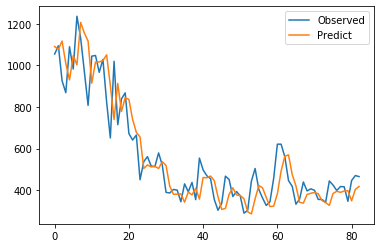

In [88]:
#예측시도
model = load_model('./model/ensembel.h5')
y_pred = model.predict([test_X, test_X, test_X, test_X])
y_pred = y_pred.reshape(-1).astype('float32')
y_real = test_Y.reshape(-1).astype('float32')

raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
rr = pd.DataFrame(raw)
reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

rmse = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
r2 = round(reg.rsquared, 3)   

plt.plot(y_real, label = 'Observed')
plt.plot(y_pred, label = 'Predict')
plt.legend()
plt.show()

In [89]:
rmse, r2

(107.819, 0.838)

In [97]:
round(rmse/test_Y.std(), 3)

0.437

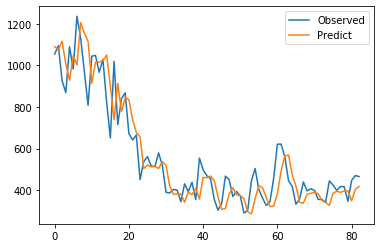

In [99]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 15)
mc = ModelCheckpoint('./model/ensembel_full.h5', monitor='val_loss', save_best_only=True)

model.fit([train_X, train_X, train_X, train_X], train_Y, 
          epochs=10000, 
          verbose=0,
          validation_data=([val_X, val_X, val_X, val_X], val_Y),
          batch_size=8,
          shuffle=False,
          callbacks=[early_stopping, mc])

model = load_model('./model/ensembel_full.h5')
y_pred = model.predict([test_X, test_X, test_X, test_X])
y_pred = y_pred.reshape(-1).astype('float32')
y_real = test_Y.reshape(-1).astype('float32')

raw= {'Observed': list(y_real), 'Predicted': list(y_pred)}
rr = pd.DataFrame(raw)
reg = sm.OLS.from_formula("Observed ~ Predicted",rr).fit()

rmse = round(math.sqrt(mean_squared_error(y_real, y_pred)), 3)
r2 = round(reg.rsquared, 3)   

plt.plot(y_real, label = 'Observed')
plt.plot(y_pred, label = 'Predict')
plt.legend()
plt.show()

In [101]:
rmse, r2

(107.716, 0.838)

In [102]:
round(rmse/test_Y.std(), 3)

0.436